### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.


Notes:
ideally, I want to use time-based cross-validation.
since I have panel data, it is not a trivial task.
need to find some solution online.
e.g., https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8.

for now, will try to do siple for loop.


In [251]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill, optuna, pickle
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [252]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [253]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [254]:
min_prd_list = range(100, 676, 25)
#min_prd_list = [500, 600]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_regularizer=0.2
optuna_trials = 50
time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/kaggle-46pkl/IMLEAP_v4.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+3))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    df = df[(df.RET>-50)&(df.RET<75)]
    meanret = df.groupby('prd').RET.mean().to_frame().reset_index().rename(columns={'RET':'mRET'})
    df = pd.merge(df, meanret, on='prd', how='left')
    df.RET = df.RET-df.mRET
    df.drop(columns='mRET', inplace=True)

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X.prd==(min_prd+windows_width-1)
    val_indx_extra = X.prd==(min_prd+windows_width+1)
    test_indx = X.prd==(min_prd+windows_width)

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    display(X_train.shape, X_val.shape, X_test.shape, X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 100)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]

    display(results)

(28169, 41)

(1079, 41)

(1054, 41)

count    28169.000000
mean       117.285988
std         10.355883
min         99.000000
25%        108.000000
50%        118.000000
75%        126.000000
max        134.000000
Name: prd, dtype: float64

count    1079.0
mean      135.0
std         0.0
min       135.0
25%       135.0
50%       135.0
75%       135.0
max       135.0
Name: prd, dtype: float64

count    1054.0
mean      136.0
std         0.0
min       136.0
25%       136.0
50%       136.0
75%       136.0
max       136.0
Name: prd, dtype: float64

Number of features before transformation:  (28169, 38)
time to do feature proprocessing: 
Number of features after transformation:  (28169, 81) (1079, 81) (1050, 81) (1054, 81)
mae of a constant model 6.613212266293419
R2 of a constant model 0.0
XGB train: 6.307657892312496 0.0993492626803929
XGB val: 6.205200608700427 -0.003078375081755791
XGB val extra: 7.315740792663031 -0.029379070819109065
XGB test: 6.89303547299647 -0.042214724225913436
XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.6} -0.0050575768545606525 26.50624704360962
XGB train: 6.377335569160736 0.071154949751429
XGB validation: 6.0107808744818785 0.05989611315422683
XGB validation extra: 7.002595612865682 0.05852597168574958
XGB test: 6.775228179269726 -0.023333107722959268


[I 2022-08-26 23:34:36,369] A new study created in memory with name: no-name-d5f2a1ae-bd5e-4651-80c7-f9bf610b5a93
[I 2022-08-26 23:34:36,745] Trial 0 finished with value: -0.012137341650712653 and parameters: {'n_estimators': 912, 'max_depth': 4, 'learning_rate': 0.02880792384850129, 'colsample_bytree': 0.9441854550105334, 'subsample': 0.518712583986066, 'alpha': 1.758392465451305, 'lambda': 200.4563773581214, 'gamma': 6.524638019815254, 'min_child_weight': 0.28761254539924874}. Best is trial 0 with value: -0.012137341650712653.
[I 2022-08-26 23:34:36,973] Trial 1 finished with value: -0.003291238859173129 and parameters: {'n_estimators': 897, 'max_depth': 3, 'learning_rate': 0.002072641053314658, 'colsample_bytree': 0.5544898208284672, 'subsample': 0.45439634848503474, 'alpha': 3.06794502850385, 'lambda': 11.940257060538377, 'gamma': 1.0014953716698849e-05, 'min_child_weight': 60.80182029592172}. Best is trial 1 with value: -0.003291238859173129.
[I 2022-08-26 23:34:37,187] Trial 2 fi

Total time for hypermarameter optimization  16.63776707649231
        n_estimators : 676
           max_depth : 2
       learning_rate : 0.001132776302387525
    colsample_bytree : 0.6912591042362537
           subsample : 0.7867638164290478
               alpha : 5.570048627188867
              lambda : 61.61709527703561
               gamma : 1.0309664033843354e-10
    min_child_weight : 40.04261310019874
best objective value : -0.003270767521556417
Optuna XGB train: 
 6.54649605677871 0.008761318806723817 
validation 
 6.206106942819278 -0.0067925487329933976 7.211222306422219 -0.007532665266719807 
test 
 6.752540567018668 -0.010852195596718683


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(36869, 41)

(1264, 41)

(1264, 41)

count    36869.000000
mean       142.605061
std         10.273794
min        124.000000
25%        134.000000
50%        143.000000
75%        152.000000
max        159.000000
Name: prd, dtype: float64

count    1264.0
mean      160.0
std         0.0
min       160.0
25%       160.0
50%       160.0
75%       160.0
max       160.0
Name: prd, dtype: float64

count    1264.0
mean      161.0
std         0.0
min       161.0
25%       161.0
50%       161.0
75%       161.0
max       161.0
Name: prd, dtype: float64

Number of features before transformation:  (36869, 38)
time to do feature proprocessing: 
Number of features after transformation:  (36869, 82) (1264, 82) (1264, 82) (1264, 82)
mae of a constant model 7.132142905307266
R2 of a constant model 0.0
XGB train: 6.885818602208441 0.08883224431247749
XGB val: 7.452694961739195 0.005567637487091104
XGB val extra: 6.306791621563685 0.02705299432344843
XGB test: 6.6911250633328585 0.004412569070578853
XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.6} 0.006990373255669313 27.847390174865723
XGB train: 6.996082545832023 0.051174613857900564
XGB validation: 7.312431874911718 0.04987960539975833
XGB validation extra: 6.203426991487196 0.06411811239877985
XGB test: 6.671424522233593 0.008134787955085154


[I 2022-08-26 23:35:25,424] A new study created in memory with name: no-name-60e3bcb5-7ab1-4ca8-8356-ca7974813310
[I 2022-08-26 23:35:27,603] Trial 0 finished with value: 0.006854176706165127 and parameters: {'n_estimators': 882, 'max_depth': 3, 'learning_rate': 0.0013842091492392277, 'colsample_bytree': 0.7442637066666472, 'subsample': 0.5762842680686489, 'alpha': 28.211756441124113, 'lambda': 219.80909320536435, 'gamma': 4.7816631107913756e-05, 'min_child_weight': 26.404056562021218}. Best is trial 0 with value: 0.006854176706165127.
[I 2022-08-26 23:35:28,156] Trial 1 finished with value: 0.00788146479387175 and parameters: {'n_estimators': 683, 'max_depth': 5, 'learning_rate': 0.01984196300382962, 'colsample_bytree': 0.2113423133923777, 'subsample': 0.683378045187986, 'alpha': 2.23773956943401, 'lambda': 3.2875266007008714, 'gamma': 2.842248873893484, 'min_child_weight': 0.17768936558145798}. Best is trial 1 with value: 0.00788146479387175.
[I 2022-08-26 23:35:29,021] Trial 2 finis

Total time for hypermarameter optimization  38.1326744556427
        n_estimators : 558
           max_depth : 3
       learning_rate : 0.025611107409019195
    colsample_bytree : 0.1753296225595843
           subsample : 0.22755527620695404
               alpha : 42.866266444933146
              lambda : 198.9852124979571
               gamma : 5.7591323436526136e-05
    min_child_weight : 0.5095921116566988
best objective value : 0.018431187568293872
Optuna XGB train: 
 7.013326284690052 0.03985050678156776 
validation 
 7.353468129520099 0.03872312818577961 6.26005180483192 0.03426539453797239 
test 
 6.688926636825698 0.0075528979905888916


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(46500, 41)

(1485, 41)

(1485, 41)

count    46500.000000
mean       167.403097
std         10.350122
min        149.000000
25%        159.000000
50%        168.000000
75%        176.000000
max        184.000000
Name: prd, dtype: float64

count    1485.0
mean      185.0
std         0.0
min       185.0
25%       185.0
50%       185.0
75%       185.0
max       185.0
Name: prd, dtype: float64

count    1485.0
mean      186.0
std         0.0
min       186.0
25%       186.0
50%       186.0
75%       186.0
max       186.0
Name: prd, dtype: float64

Number of features before transformation:  (46500, 38)
time to do feature proprocessing: 
Number of features after transformation:  (46500, 84) (1485, 84) (1474, 84) (1485, 84)
mae of a constant model 7.611699806708129
R2 of a constant model 0.0
XGB train: 7.1529799389174675 0.07120427640683447
XGB val: 9.183082887242872 -0.00016061966534830496
XGB val extra: 8.553188621861128 0.01153515650833925
XGB test: 8.77751868102996 0.016670313684464477
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 2, 'n_estimators': 800, 'subsample': 0.6} 0.005150627933506624 29.847999334335327
XGB train: 7.313471429509544 0.01831733337915975
XGB validation: 9.106041737477625 0.01610699090269707
XGB validation extra: 8.521897418727352 0.029404842200184467
XGB test: 8.765554307865417 0.021497743796950575


[I 2022-08-26 23:36:38,324] A new study created in memory with name: no-name-9b03bc7e-5914-461c-8e5d-7a0d3b9c238a
[I 2022-08-26 23:36:38,797] Trial 0 finished with value: 0.00461864788181181 and parameters: {'n_estimators': 511, 'max_depth': 4, 'learning_rate': 0.021026281180678515, 'colsample_bytree': 0.12587276241217654, 'subsample': 0.8759847126674257, 'alpha': 18.260191481764174, 'lambda': 0.8155172681726066, 'gamma': 0.0004050630641105523, 'min_child_weight': 1.600629091869399}. Best is trial 0 with value: 0.00461864788181181.
[I 2022-08-26 23:36:39,282] Trial 1 finished with value: 0.0045414323062593406 and parameters: {'n_estimators': 824, 'max_depth': 4, 'learning_rate': 0.029270973387056046, 'colsample_bytree': 0.4244150238463113, 'subsample': 0.5721574788936182, 'alpha': 0.18832998966879028, 'lambda': 2.0781058224968914, 'gamma': 3.3045090585545175e-05, 'min_child_weight': 1.6530329950947704}. Best is trial 0 with value: 0.00461864788181181.
[I 2022-08-26 23:36:41,801] Trial 

Total time for hypermarameter optimization  41.9680597782135
        n_estimators : 998
           max_depth : 2
       learning_rate : 0.01772244441522717
    colsample_bytree : 0.17465566738079152
           subsample : 0.21708695492035562
               alpha : 1.1790067681075638
              lambda : 9.563718062963344
               gamma : 4.8948049790706356e-08
    min_child_weight : 41.94622185595376
best objective value : 0.007658553960411818
Optuna XGB train: 
 7.27733385470936 0.02887245193978505 
validation 
 9.052835812774754 0.027674222832288486 8.592525429839725 0.005483206632040383 
test 
 8.794947181334084 0.011792709657702738


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(54189, 41)

(1872, 41)

(1866, 41)

count    54189.000000
mean       192.062190
std         10.505933
min        174.000000
25%        183.000000
50%        192.000000
75%        201.000000
max        209.000000
Name: prd, dtype: float64

count    1872.0
mean      210.0
std         0.0
min       210.0
25%       210.0
50%       210.0
75%       210.0
max       210.0
Name: prd, dtype: float64

count    1866.0
mean      211.0
std         0.0
min       211.0
25%       211.0
50%       211.0
75%       211.0
max       211.0
Name: prd, dtype: float64

Number of features before transformation:  (54189, 38)
time to do feature proprocessing: 
Number of features after transformation:  (54189, 85) (1872, 85) (1862, 85) (1866, 85)
mae of a constant model 8.636817210018549
R2 of a constant model 0.0
XGB train: 8.326758470817362 0.06953408996443566
XGB val: 9.01992110876032 -0.014829437201131501
XGB val extra: 6.920020436375451 0.01720471239775223
XGB test: 8.364310118331288 -0.013961796556174022
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.6} -0.006588115215127921 30.436322450637817
XGB train: 8.522081984399062 0.0189364088840418
XGB validation: 8.937326195587652 0.0006132084849538311
XGB validation extra: 6.914975688220112 0.019526759181262787
XGB test: 8.290140368238243 -0.0029521456054615314


[I 2022-08-26 23:37:56,866] A new study created in memory with name: no-name-86c29e9c-b794-4fed-b6f1-264f10342dc0
[I 2022-08-26 23:37:57,186] Trial 0 finished with value: -0.0018915893243664605 and parameters: {'n_estimators': 855, 'max_depth': 3, 'learning_rate': 0.009237954462360745, 'colsample_bytree': 0.3808384784630887, 'subsample': 0.21038148950534918, 'alpha': 27.327767011714705, 'lambda': 0.32649832770592585, 'gamma': 0.8806040134604761, 'min_child_weight': 9.644935383442919}. Best is trial 0 with value: -0.0018915893243664605.
[I 2022-08-26 23:37:57,554] Trial 1 finished with value: -0.0015008800629282338 and parameters: {'n_estimators': 739, 'max_depth': 4, 'learning_rate': 0.015005479878772808, 'colsample_bytree': 0.2001668847463971, 'subsample': 0.4112248186774553, 'alpha': 0.4337713526262023, 'lambda': 133.06689358944126, 'gamma': 0.001581800099877284, 'min_child_weight': 0.9840236117185245}. Best is trial 1 with value: -0.0015008800629282338.
[I 2022-08-26 23:37:57,893] T

Total time for hypermarameter optimization  19.166478633880615
        n_estimators : 631
           max_depth : 2
       learning_rate : 0.029438276328245434
    colsample_bytree : 0.689894117894502
           subsample : 0.8093179583722767
               alpha : 30.0077778468691
              lambda : 29.40328303760396
               gamma : 0.00042492410537195376
    min_child_weight : 0.4562558643873611
best objective value : 0.0033307974108247374
Optuna XGB train: 
 8.425293361149587 0.03913601649128928 
validation 
 8.82915591457473 0.023767843922844922 6.928565899802984 0.013377927803503109 
test 
 8.299699990184548 -0.00413710269046641


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(66975, 41)

(2335, 41)

(2336, 41)

count    66975.000000
mean       217.621262
std         10.252781
min        199.000000
25%        209.000000
50%        218.000000
75%        227.000000
max        234.000000
Name: prd, dtype: float64

count    2335.0
mean      235.0
std         0.0
min       235.0
25%       235.0
50%       235.0
75%       235.0
max       235.0
Name: prd, dtype: float64

count    2336.0
mean      236.0
std         0.0
min       236.0
25%       236.0
50%       236.0
75%       236.0
max       236.0
Name: prd, dtype: float64

Number of features before transformation:  (66975, 38)
time to do feature proprocessing: 
Number of features after transformation:  (66975, 85) (2335, 85) (2330, 85) (2336, 85)
mae of a constant model 7.825950383660284
R2 of a constant model 0.0
XGB train: 7.743261208590477 0.061511933585520207
XGB val: 7.908179717979609 0.008184736987339791
XGB val extra: 6.682926402689639 0.02583817693792434
XGB test: 6.744273761241255 0.012472925665387158
XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.6} 0.011033849212527591 34.91966915130615
XGB train: 7.63932555967419 0.09631627272318855
XGB validation: 7.715361602440909 0.06621230072210682
XGB validation extra: 6.493681573286141 0.08767677590525957
XGB test: 6.759866648589539 0.00814619340503564


[I 2022-08-26 23:38:57,779] A new study created in memory with name: no-name-4516e8a5-8845-4fa7-bc08-59c090c53ce8
[I 2022-08-26 23:38:58,717] Trial 0 finished with value: 0.01421704664432748 and parameters: {'n_estimators': 667, 'max_depth': 2, 'learning_rate': 0.022645393726851953, 'colsample_bytree': 0.662934235195856, 'subsample': 0.5620081630141135, 'alpha': 0.31431116105098017, 'lambda': 2.796731132889373, 'gamma': 4.818335783648929, 'min_child_weight': 5.618320344545251}. Best is trial 0 with value: 0.01421704664432748.
[I 2022-08-26 23:39:00,488] Trial 1 finished with value: 0.01285755232291974 and parameters: {'n_estimators': 602, 'max_depth': 4, 'learning_rate': 0.011296586416940552, 'colsample_bytree': 0.7807021138086617, 'subsample': 0.4412152664136254, 'alpha': 21.686378410740197, 'lambda': 31.15454774308523, 'gamma': 8.424589824527737e-10, 'min_child_weight': 0.19804530751404018}. Best is trial 0 with value: 0.01421704664432748.
[I 2022-08-26 23:39:01,930] Trial 2 finished

Total time for hypermarameter optimization  81.09112620353699
        n_estimators : 887
           max_depth : 5
       learning_rate : 0.024706022588313503
    colsample_bytree : 0.11304930486218215
           subsample : 0.1647831874819745
               alpha : 10.381663855833056
              lambda : 207.7965489686903
               gamma : 2.4652265091282024e-07
    min_child_weight : 0.1002412785078584
best objective value : 0.01882821772891059
Optuna XGB train: 
 7.75053400032338 0.053050781705771266 
validation 
 7.746570846497251 0.0487378129317827 6.701879939445942 0.02222930031055992 
test 
 6.744150856021864 0.008407377425922902


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(79782, 41)

(2231, 41)

(2204, 41)

count    79782.000000
mean       241.830739
std         10.226094
min        224.000000
25%        233.000000
50%        242.000000
75%        251.000000
max        259.000000
Name: prd, dtype: float64

count    2231.0
mean      260.0
std         0.0
min       260.0
25%       260.0
50%       260.0
75%       260.0
max       260.0
Name: prd, dtype: float64

count    2204.0
mean      261.0
std         0.0
min       261.0
25%       261.0
50%       261.0
75%       261.0
max       261.0
Name: prd, dtype: float64

Number of features before transformation:  (79782, 38)
time to do feature proprocessing: 
Number of features after transformation:  (79782, 85) (2231, 85) (2217, 85) (2204, 85)
mae of a constant model 7.748260740322899
R2 of a constant model 0.0
XGB train: 7.460976948120806 0.04989091374285903
XGB val: 8.727442268859269 0.016617251473114436
XGB val extra: 8.077320053159745 0.014669399287961182
XGB test: 10.624358321595858 0.020267926041416473
XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.01766698212443507 36.95713257789612
XGB train: 7.474538183547404 0.04674549498805913
XGB validation: 8.596960811306474 0.05400144869788548
XGB validation extra: 7.914642042107002 0.06849180111046471
XGB test: 10.588861468532654 0.02529025533689344


[I 2022-08-26 23:41:07,062] A new study created in memory with name: no-name-5c5f1ed0-98a9-4ca8-937f-534b2b1d6157
[I 2022-08-26 23:41:09,621] Trial 0 finished with value: 0.007356560050563754 and parameters: {'n_estimators': 776, 'max_depth': 3, 'learning_rate': 0.001316984206538892, 'colsample_bytree': 0.44972784663136417, 'subsample': 0.20159855107644115, 'alpha': 0.7468320458088458, 'lambda': 0.16750280281674268, 'gamma': 1.460861022030049e-05, 'min_child_weight': 4.006504001845125}. Best is trial 0 with value: 0.007356560050563754.
[I 2022-08-26 23:41:12,084] Trial 1 finished with value: 0.010489473126321137 and parameters: {'n_estimators': 588, 'max_depth': 4, 'learning_rate': 0.02694116584757481, 'colsample_bytree': 0.61592819237645, 'subsample': 0.9364857949701435, 'alpha': 1.8993494474447195, 'lambda': 28.063718948972813, 'gamma': 2.8076855625160505e-10, 'min_child_weight': 0.4926559780449925}. Best is trial 1 with value: 0.010489473126321137.
[I 2022-08-26 23:41:14,106] Trial 

Total time for hypermarameter optimization  84.85050082206726
        n_estimators : 888
           max_depth : 2
       learning_rate : 0.024959619355635673
    colsample_bytree : 0.7942604850073494
           subsample : 0.4405944292534646
               alpha : 8.973549745895445
              lambda : 37.01577784497032
               gamma : 4.927543264696455e-08
    min_child_weight : 3.548903601195278
best objective value : 0.01827787829366314
Optuna XGB train: 
 7.5168879892135525 0.030399397453234722 
validation 
 8.657306459992675 0.034755991343826786 8.046781280199122 0.021911884678220805 
test 
 10.594236894613575 0.024628566977529687


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(79162, 41)

(2145, 41)

(2137, 41)

count    79162.000000
mean       266.337409
std         10.396123
min        249.000000
25%        257.000000
50%        266.000000
75%        275.000000
max        284.000000
Name: prd, dtype: float64

count    2145.0
mean      285.0
std         0.0
min       285.0
25%       285.0
50%       285.0
75%       285.0
max       285.0
Name: prd, dtype: float64

count    2137.0
mean      286.0
std         0.0
min       286.0
25%       286.0
50%       286.0
75%       286.0
max       286.0
Name: prd, dtype: float64

Number of features before transformation:  (79162, 38)
time to do feature proprocessing: 
Number of features after transformation:  (79162, 85) (2145, 85) (2123, 85) (2137, 85)
mae of a constant model 8.11874542158204
R2 of a constant model 0.0
XGB train: 7.989726165770913 0.04574106643165299
XGB val: 7.230642818671135 0.006387854977991436
XGB val extra: 8.249036348156604 0.001989263307294542
XGB test: 7.349965616394131 -0.005745749216557128
XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.6} 0.006508998454320847 37.327587366104126
XGB train: 7.970698169005427 0.05230498694157615
XGB validation: 7.042358249966991 0.06674580644953665
XGB validation extra: 8.095002119727507 0.04950396482351438
XGB test: 7.293064964771333 0.011374365888345284


[I 2022-08-26 23:43:17,965] A new study created in memory with name: no-name-760f8f52-5838-42ef-a142-ea2974e06a41
[I 2022-08-26 23:43:18,676] Trial 0 finished with value: -0.0006778636309569653 and parameters: {'n_estimators': 947, 'max_depth': 3, 'learning_rate': 0.006393587669528085, 'colsample_bytree': 0.5075639899616909, 'subsample': 0.4476494740876925, 'alpha': 0.266463751830149, 'lambda': 7.0125345833178665, 'gamma': 4.281996850033823e-06, 'min_child_weight': 0.30894788439448156}. Best is trial 0 with value: -0.0006778636309569653.
[I 2022-08-26 23:43:21,440] Trial 1 finished with value: -4.4135903721143326e-05 and parameters: {'n_estimators': 846, 'max_depth': 5, 'learning_rate': 0.003453325619748644, 'colsample_bytree': 0.5787406516379383, 'subsample': 0.4095908127572895, 'alpha': 17.16643499125789, 'lambda': 462.4743786522756, 'gamma': 8.269459202134053e-07, 'min_child_weight': 65.38916533808194}. Best is trial 1 with value: -4.4135903721143326e-05.
[I 2022-08-26 23:43:23,423]

Total time for hypermarameter optimization  46.88589334487915
        n_estimators : 951
           max_depth : 3
       learning_rate : 0.011545072426062009
    colsample_bytree : 0.6332677640033227
           subsample : 0.46617256521151174
               alpha : 23.646100339767006
              lambda : 8.534654591674261
               gamma : 1.9044435893381484e-06
    min_child_weight : 0.847993531885863
best objective value : 0.0006752841433914413
Optuna XGB train: 
 8.031392259473606 0.03236585474282405 
validation 
 7.128870472357604 0.03666756241031488 8.238232776416293 0.0031778005712851387 
test 
 7.324813782950334 0.0026179252467046776


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(78167, 41)

(2219, 41)

(2215, 41)

count    78167.000000
mean       291.620786
std         10.427445
min        274.000000
25%        283.000000
50%        292.000000
75%        301.000000
max        309.000000
Name: prd, dtype: float64

count    2219.0
mean      310.0
std         0.0
min       310.0
25%       310.0
50%       310.0
75%       310.0
max       310.0
Name: prd, dtype: float64

count    2215.0
mean      311.0
std         0.0
min       311.0
25%       311.0
50%       311.0
75%       311.0
max       311.0
Name: prd, dtype: float64

Number of features before transformation:  (78167, 38)
time to do feature proprocessing: 
Number of features after transformation:  (78167, 85) (2219, 85) (2211, 85) (2215, 85)
mae of a constant model 8.36397843250023
R2 of a constant model 0.0
XGB train: 8.281465889106647 0.05612555922400386
XGB val: 6.86379524742586 -0.010528149134774178
XGB val extra: 7.0518957162176985 0.02315408982922762
XGB test: 7.299970621110206 0.02093634999764815
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.6} 0.0023875304748295356 35.5103394985199
XGB train: 8.423357725716123 0.015096282299015829
XGB validation: 6.8247340071306555 0.008037155503940685
XGB validation extra: 7.022705794575186 0.02795942183022837
XGB test: 7.273211655786389 0.016923528937609067


[I 2022-08-26 23:44:48,654] A new study created in memory with name: no-name-8b56c200-ed7c-48bd-b462-bb892752a8ca
[I 2022-08-26 23:44:51,882] Trial 0 finished with value: 0.0070614842490283715 and parameters: {'n_estimators': 850, 'max_depth': 5, 'learning_rate': 0.0016251025469002703, 'colsample_bytree': 0.310239643826388, 'subsample': 0.7441695382566825, 'alpha': 2.2380775697019417, 'lambda': 0.2266220014412411, 'gamma': 0.00024046716049135844, 'min_child_weight': 64.33403869822523}. Best is trial 0 with value: 0.0070614842490283715.
[I 2022-08-26 23:44:52,718] Trial 1 finished with value: 0.009768851481119367 and parameters: {'n_estimators': 635, 'max_depth': 5, 'learning_rate': 0.022469518078248752, 'colsample_bytree': 0.8759468972472615, 'subsample': 0.6612351643006631, 'alpha': 2.6820880544435677, 'lambda': 83.98048804664143, 'gamma': 1.0990342987018685e-08, 'min_child_weight': 1.4403091459388926}. Best is trial 1 with value: 0.009768851481119367.
[I 2022-08-26 23:44:53,776] Tria

Total time for hypermarameter optimization  39.04204726219177
        n_estimators : 501
           max_depth : 2
       learning_rate : 0.0149978761935178
    colsample_bytree : 0.8414394467637558
           subsample : 0.5780184575096654
               alpha : 0.37024057641906627
              lambda : 279.1371068499995
               gamma : 10.98815394184602
    min_child_weight : 65.53653036300373
best objective value : 0.012606868976103414
Optuna XGB train: 
 8.389995748253554 0.022485328885798683 
validation 
 6.811386865669163 0.007023266081886859 7.026405517772598 0.02844939745642272 
test 
 7.273566701527284 0.022965317051282907


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(82271, 41)

(2312, 41)

(2290, 41)

count    82271.000000
mean       316.778950
std         10.347398
min        299.000000
25%        308.000000
50%        317.000000
75%        326.000000
max        334.000000
Name: prd, dtype: float64

count    2312.0
mean      335.0
std         0.0
min       335.0
25%       335.0
50%       335.0
75%       335.0
max       335.0
Name: prd, dtype: float64

count    2290.0
mean      336.0
std         0.0
min       336.0
25%       336.0
50%       336.0
75%       336.0
max       336.0
Name: prd, dtype: float64

Number of features before transformation:  (82271, 38)
time to do feature proprocessing: 
Number of features after transformation:  (82271, 85) (2312, 85) (2269, 85) (2290, 85)
mae of a constant model 8.413480065440206
R2 of a constant model 0.0
XGB train: 8.091700071738112 0.057806579450426554
XGB val: 9.514934320092038 0.016672167470392463
XGB val extra: 8.889329736033249 0.006506178550004793
XGB test: 9.038946873836187 9.238500665242899e-05
XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.6} 0.020607442809807086 36.931578159332275
XGB train: 8.176653836161005 0.02972337370568523
XGB validation: 9.440239558248074 0.035965397024250834
XGB validation extra: 8.834562486396985 0.021068733694735498
XGB test: 9.037071184246726 0.0010723733891713216


[I 2022-08-26 23:46:10,986] A new study created in memory with name: no-name-9a7b8a8e-fc32-4fd1-b400-49c1bdc44c47
[I 2022-08-26 23:46:12,441] Trial 0 finished with value: 0.011492066754421182 and parameters: {'n_estimators': 681, 'max_depth': 2, 'learning_rate': 0.018909200184806373, 'colsample_bytree': 0.3672754301498435, 'subsample': 0.35560709704470417, 'alpha': 7.8696079390002875, 'lambda': 18.46134211338453, 'gamma': 2.5472871905398276e-08, 'min_child_weight': 1.4102773775185657}. Best is trial 0 with value: 0.011492066754421182.
[I 2022-08-26 23:46:14,194] Trial 1 finished with value: 0.010433716131185156 and parameters: {'n_estimators': 697, 'max_depth': 4, 'learning_rate': 0.009734936785863634, 'colsample_bytree': 0.6115246790624351, 'subsample': 0.9200862786693399, 'alpha': 0.19610489425518476, 'lambda': 0.13624329618990286, 'gamma': 0.0001978501461354492, 'min_child_weight': 2.9044700329184754}. Best is trial 0 with value: 0.011492066754421182.
[I 2022-08-26 23:46:15,355] Tri

Total time for hypermarameter optimization  108.41886496543884
        n_estimators : 922
           max_depth : 3
       learning_rate : 0.008349335703472953
    colsample_bytree : 0.9400889216446782
           subsample : 0.6156400852803579
               alpha : 0.8757086706209811
              lambda : 498.5458119106495
               gamma : 7.208390844863128e-07
    min_child_weight : 80.35689779878035
best objective value : 0.014088038485060305
Optuna XGB train: 
 8.165218892710167 0.030927977759568903 
validation 
 9.41956258966645 0.03736365579952294 8.878372084676192 0.00894124139439978 
test 
 9.036645208656742 0.0010432886681848164


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(85126, 41)

(2359, 41)

(2330, 41)

count    85126.000000
mean       341.614877
std         10.396431
min        324.000000
25%        333.000000
50%        342.000000
75%        351.000000
max        359.000000
Name: prd, dtype: float64

count    2359.0
mean      360.0
std         0.0
min       360.0
25%       360.0
50%       360.0
75%       360.0
max       360.0
Name: prd, dtype: float64

count    2330.0
mean      361.0
std         0.0
min       361.0
25%       361.0
50%       361.0
75%       361.0
max       361.0
Name: prd, dtype: float64

Number of features before transformation:  (85126, 38)
time to do feature proprocessing: 
Number of features after transformation:  (85126, 85) (2359, 85) (2307, 85) (2330, 85)
mae of a constant model 8.86509889092528
R2 of a constant model 0.0
XGB train: 8.733065152266942 0.04722709986548612
XGB val: 8.382025706115792 -7.667659555110617e-05
XGB val extra: 9.284942604768835 0.00011515187683053263
XGB test: 7.531470883837012 0.003567772536418601
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.6} 0.002489495972414435 37.356465339660645
XGB train: 8.824670531076494 0.022964749240658056
XGB validation: 8.320711103997477 0.01710877870826455
XGB validation extra: 9.175036585494507 0.028397241662670325
XGB test: 7.510219728971661 0.010408209487120512


[I 2022-08-26 23:48:45,578] A new study created in memory with name: no-name-28be2e8a-9f1d-4546-bae2-ad6596b1bedd
[I 2022-08-26 23:48:47,563] Trial 0 finished with value: 0.0027460381618459317 and parameters: {'n_estimators': 706, 'max_depth': 4, 'learning_rate': 0.0014832216321493397, 'colsample_bytree': 0.33420751426684814, 'subsample': 0.18610136451096523, 'alpha': 0.4733565748109417, 'lambda': 1.1988497875654243, 'gamma': 4.880686980763838e-09, 'min_child_weight': 24.177934308598758}. Best is trial 0 with value: 0.0027460381618459317.
[I 2022-08-26 23:48:48,149] Trial 1 finished with value: 0.003434225373017119 and parameters: {'n_estimators': 572, 'max_depth': 4, 'learning_rate': 0.02255754347601787, 'colsample_bytree': 0.36938780478934796, 'subsample': 0.6053754979460925, 'alpha': 0.4183666113645201, 'lambda': 1.6692866592206628, 'gamma': 5.4747529405204546e-05, 'min_child_weight': 0.21730216695205246}. Best is trial 1 with value: 0.003434225373017119.
[I 2022-08-26 23:48:48,930]

Total time for hypermarameter optimization  37.925923585891724
        n_estimators : 788
           max_depth : 3
       learning_rate : 0.016664620945551746
    colsample_bytree : 0.7391454041018618
           subsample : 0.5561400823600013
               alpha : 3.5045415487230884
              lambda : 69.77738307038206
               gamma : 0.005769494196213733
    min_child_weight : 2.3087686449959817
best objective value : 0.005886635565708742
Optuna XGB train: 
 8.772477728385864 0.03425819527488516 
validation 
 8.29655530000339 0.02659261576911398 9.289367646641548 0.00021940501544537305 
test 
 7.522458286503157 0.005250315052022669


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(86525, 41)

(2346, 41)

(2318, 41)

count    86525.000000
mean       366.510604
std         10.388374
min        349.000000
25%        357.000000
50%        366.000000
75%        376.000000
max        384.000000
Name: prd, dtype: float64

count    2346.0
mean      385.0
std         0.0
min       385.0
25%       385.0
50%       385.0
75%       385.0
max       385.0
Name: prd, dtype: float64

count    2318.0
mean      386.0
std         0.0
min       386.0
25%       386.0
50%       386.0
75%       386.0
max       386.0
Name: prd, dtype: float64

Number of features before transformation:  (86525, 38)
time to do feature proprocessing: 
Number of features after transformation:  (86525, 86) (2346, 86) (2610, 86) (2318, 86)
mae of a constant model 8.840500354133429
R2 of a constant model 0.0
XGB train: 8.562905844495273 0.04670825564653647
XGB val: 10.527740523699148 0.021300346785617985
XGB val extra: 9.319794429468487 0.016115242465840285
XGB test: 8.875064932819427 -0.00879510174767284
XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.6} 0.022875798989792306 37.87336850166321
XGB train: 8.56238929492026 0.046876368556779124
XGB validation: 10.32372184879376 0.06349487542977317
XGB validation extra: 9.146381443809611 0.06443084503742291
XGB test: 8.877039071378235 -0.008644849102869001


[I 2022-08-26 23:50:10,604] A new study created in memory with name: no-name-2bdb6e9a-927e-4ffe-a2f4-f78a8e21a442
[I 2022-08-26 23:50:11,684] Trial 0 finished with value: 0.016584681591195905 and parameters: {'n_estimators': 532, 'max_depth': 4, 'learning_rate': 0.028878711796882024, 'colsample_bytree': 0.6005651628627964, 'subsample': 0.5425303598340673, 'alpha': 17.952004911908194, 'lambda': 1.0950928488040126, 'gamma': 0.0017595350475803377, 'min_child_weight': 15.728740626831094}. Best is trial 0 with value: 0.016584681591195905.
[I 2022-08-26 23:50:13,144] Trial 1 finished with value: 0.017498527376569494 and parameters: {'n_estimators': 646, 'max_depth': 3, 'learning_rate': 0.021036785225870706, 'colsample_bytree': 0.2724948919198713, 'subsample': 0.47961836916573886, 'alpha': 25.063051535112944, 'lambda': 32.98330130696086, 'gamma': 1.7956667508968972e-07, 'min_child_weight': 3.8236138353793767}. Best is trial 1 with value: 0.017498527376569494.
[I 2022-08-26 23:50:17,171] Trial

Total time for hypermarameter optimization  102.06182050704956
        n_estimators : 727
           max_depth : 3
       learning_rate : 0.01721939709868814
    colsample_bytree : 0.6577175663172794
           subsample : 0.6312926077468985
               alpha : 0.22992380866721207
              lambda : 233.70558487285697
               gamma : 1.4527638908070727e-09
    min_child_weight : 55.29663421130814
best objective value : 0.01978267447559643
Optuna XGB train: 
 8.610322406887498 0.029757137499548114 
validation 
 10.38930416556453 0.04507232468096556 9.314733017368097 0.015143970564401754 
test 
 8.8569197653884 -0.005809622062127318


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(89612, 41)

(2457, 41)

(2553, 41)

count    89612.000000
mean       391.671082
std         10.370548
min        374.000000
25%        383.000000
50%        392.000000
75%        401.000000
max        409.000000
Name: prd, dtype: float64

count    2457.0
mean      410.0
std         0.0
min       410.0
25%       410.0
50%       410.0
75%       410.0
max       410.0
Name: prd, dtype: float64

count    2553.0
mean      411.0
std         0.0
min       411.0
25%       411.0
50%       411.0
75%       411.0
max       411.0
Name: prd, dtype: float64

Number of features before transformation:  (89612, 38)
time to do feature proprocessing: 
Number of features after transformation:  (89612, 86) (2457, 86) (2530, 86) (2553, 86)
mae of a constant model 9.939170380846681
R2 of a constant model 0.0
XGB train: 9.862608807870279 0.03857263701672686
XGB val: 9.07903533174013 0.007538315798967243
XGB val extra: 8.545350218524568 0.018163896754168296
XGB test: 9.51543146906129 0.004975726888502896
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.6} 0.005732765869139733 38.07117986679077
XGB train: 9.94857166402877 0.017117392922588848
XGB validation: 9.025929500681489 0.020265510203730464
XGB validation extra: 8.48218946778078 0.028459757503490835
XGB test: 9.499924255725974 0.007301102650262958


[I 2022-08-26 23:52:39,566] A new study created in memory with name: no-name-b61f0b51-96e2-4101-907e-7512401bfcd0
[I 2022-08-26 23:52:43,349] Trial 0 finished with value: 0.0038350071155718755 and parameters: {'n_estimators': 843, 'max_depth': 4, 'learning_rate': 0.0031795390023408527, 'colsample_bytree': 0.05331777048579692, 'subsample': 0.3240451208563465, 'alpha': 0.9077741192250693, 'lambda': 1.7483621795905326, 'gamma': 0.14124156964629284, 'min_child_weight': 1.047756067331656}. Best is trial 0 with value: 0.0038350071155718755.
[I 2022-08-26 23:52:44,671] Trial 1 finished with value: 0.005773562383165487 and parameters: {'n_estimators': 966, 'max_depth': 5, 'learning_rate': 0.025700385315261268, 'colsample_bytree': 0.16678377342505088, 'subsample': 0.6295989455829107, 'alpha': 5.261724828200952, 'lambda': 8.542501111875097, 'gamma': 0.003917704447128191, 'min_child_weight': 3.561555246049796}. Best is trial 1 with value: 0.005773562383165487.
[I 2022-08-26 23:52:45,618] Trial 2 

Total time for hypermarameter optimization  77.83749270439148
        n_estimators : 502
           max_depth : 4
       learning_rate : 0.028395979538928456
    colsample_bytree : 0.5511012978315664
           subsample : 0.36037575947768463
               alpha : 1.3997067750848664
              lambda : 4.7032291226688265
               gamma : 0.02522438759870898
    min_child_weight : 97.15295475115165
best objective value : 0.01313886174482921
Optuna XGB train: 
 9.838506012481151 0.04332293891447925 
validation 
 8.926793188672209 0.05019533313675417 8.520074960688264 0.020163269469854694 
test 
 9.497953826302664 0.012075151248015947


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(90704, 47)

(2625, 47)

(2593, 47)

count    90704.000000
mean       416.424402
std         10.428362
min        399.000000
25%        407.000000
50%        416.000000
75%        425.000000
max        434.000000
Name: prd, dtype: float64

count    2625.0
mean      435.0
std         0.0
min       435.0
25%       435.0
50%       435.0
75%       435.0
max       435.0
Name: prd, dtype: float64

count    2593.0
mean      436.0
std         0.0
min       436.0
25%       436.0
50%       436.0
75%       436.0
max       436.0
Name: prd, dtype: float64

Number of features before transformation:  (90704, 44)
time to do feature proprocessing: 
Number of features after transformation:  (90704, 92) (2625, 92) (2583, 92) (2593, 92)
mae of a constant model 9.66046200301964
R2 of a constant model 0.0
XGB train: 9.579446816573592 0.040178985780626286
XGB val: 8.655405133466001 0.0015511155794635245
XGB val extra: 8.5197140974799 0.002011219750773674
XGB test: 9.63823272844366 0.0049762282349634646
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 2, 'n_estimators': 600, 'subsample': 0.6} 0.005673597794636942 40.5330855846405
XGB train: 9.693928844533609 0.008675820997019912
XGB validation: 8.619785878843052 0.010040548663920679
XGB validation extra: 8.506339430866136 0.008455113374762013
XGB test: 9.635688936099093 0.00449593126658121


[I 2022-08-26 23:54:46,412] A new study created in memory with name: no-name-e4316492-0e85-4094-a24c-84b1cfde7377
[I 2022-08-26 23:54:48,008] Trial 0 finished with value: 0.004050250337645811 and parameters: {'n_estimators': 859, 'max_depth': 4, 'learning_rate': 0.006943181608941177, 'colsample_bytree': 0.6779174053501262, 'subsample': 0.5891093593425545, 'alpha': 14.150322732721898, 'lambda': 85.24277659311086, 'gamma': 7.901510899682103e-08, 'min_child_weight': 7.104924237780464}. Best is trial 0 with value: 0.004050250337645811.
[I 2022-08-26 23:54:49,004] Trial 1 finished with value: 0.0038524740678654635 and parameters: {'n_estimators': 989, 'max_depth': 2, 'learning_rate': 0.014410648253188905, 'colsample_bytree': 0.6244107384187682, 'subsample': 0.15538068443307534, 'alpha': 32.65482140120299, 'lambda': 5.850874800621905, 'gamma': 1.4132863577990865e-05, 'min_child_weight': 31.386700503315268}. Best is trial 0 with value: 0.004050250337645811.
[I 2022-08-26 23:54:49,952] Trial 2

Total time for hypermarameter optimization  65.23466444015503
        n_estimators : 711
           max_depth : 2
       learning_rate : 0.010602145651978796
    colsample_bytree : 0.8177689177279408
           subsample : 0.9475628652067339
               alpha : 5.253784044409773
              lambda : 2.4988747383539147
               gamma : 3.912602628142273e-10
    min_child_weight : 1.1128107643382399
best objective value : 0.006049260715278471
Optuna XGB train: 
 9.675955049522686 0.012501965036948448 
validation 
 8.604744392335823 0.013072856837618274 8.509256192112252 0.004527114584170544 
test 
 9.63170046089553 0.0035721060491885614


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(92976, 47)

(2877, 47)

(2861, 47)

count    92976.000000
mean       441.701536
std         10.430691
min        424.000000
25%        433.000000
50%        442.000000
75%        451.000000
max        459.000000
Name: prd, dtype: float64

count    2877.0
mean      460.0
std         0.0
min       460.0
25%       460.0
50%       460.0
75%       460.0
max       460.0
Name: prd, dtype: float64

count    2861.0
mean      461.0
std         0.0
min       461.0
25%       461.0
50%       461.0
75%       461.0
max       461.0
Name: prd, dtype: float64

Number of features before transformation:  (92976, 44)
time to do feature proprocessing: 
Number of features after transformation:  (92976, 92) (2877, 92) (2844, 92) (2861, 92)
mae of a constant model 9.382559132895377
R2 of a constant model 0.0
XGB train: 9.191827336515857 0.04164008395259211
XGB val: 9.194752878238296 -0.002293915150427095
XGB val extra: 10.075066205730572 0.01891796768909837
XGB test: 9.278129061879737 0.006354747052123133
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 2, 'n_estimators': 600, 'subsample': 0.6} 0.008484119469377438 41.42604303359985
XGB train: 9.3064344721859 0.009202781398687465
XGB validation: 9.122502795003063 0.01461193529577387
XGB validation extra: 10.067900975818295 0.01967446272301343
XGB test: 9.298511540768096 0.007321183734402159


[I 2022-08-26 23:56:41,021] A new study created in memory with name: no-name-f20d94b1-131b-4215-b12c-72a01bc27ffb
[I 2022-08-26 23:56:42,160] Trial 0 finished with value: 0.011445710464225 and parameters: {'n_estimators': 578, 'max_depth': 4, 'learning_rate': 0.02567158082260056, 'colsample_bytree': 0.9067281028653865, 'subsample': 0.3478541138953366, 'alpha': 1.1720539695310705, 'lambda': 402.8465681731574, 'gamma': 0.7947424468903723, 'min_child_weight': 0.28605181348354425}. Best is trial 0 with value: 0.011445710464225.
[I 2022-08-26 23:56:43,438] Trial 1 finished with value: 0.012933160854568193 and parameters: {'n_estimators': 611, 'max_depth': 2, 'learning_rate': 0.025377885745696372, 'colsample_bytree': 0.2702442949502166, 'subsample': 0.289655712000141, 'alpha': 0.361752160920566, 'lambda': 2.8183928587230973, 'gamma': 0.0012785396218151343, 'min_child_weight': 5.554223177695262}. Best is trial 1 with value: 0.012933160854568193.
[I 2022-08-26 23:56:44,208] Trial 2 finished wi

Total time for hypermarameter optimization  60.74957036972046
        n_estimators : 835
           max_depth : 2
       learning_rate : 0.028244265668747343
    colsample_bytree : 0.11889155594399586
           subsample : 0.13701060796532613
               alpha : 2.8273158681121733
              lambda : 0.4503004528236863
               gamma : 0.049910873889855684
    min_child_weight : 2.484906014296096
best objective value : 0.01430809774370836
Optuna XGB train: 
 9.268588882111858 0.019401073676134306 
validation 
 9.106460501246055 0.02170221057463073 10.075998652121248 0.01928700354753754 
test 
 9.278254562822006 0.006372082362546161


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(99700, 47)

(2833, 47)

(2787, 47)

count    99700.000000
mean       466.677944
std         10.329035
min        449.000000
25%        458.000000
50%        467.000000
75%        476.000000
max        484.000000
Name: prd, dtype: float64

count    2833.0
mean      485.0
std         0.0
min       485.0
25%       485.0
50%       485.0
75%       485.0
max       485.0
Name: prd, dtype: float64

count    2787.0
mean      486.0
std         0.0
min       486.0
25%       486.0
50%       486.0
75%       486.0
max       486.0
Name: prd, dtype: float64

Number of features before transformation:  (99700, 44)
time to do feature proprocessing: 
Number of features after transformation:  (99700, 92) (2833, 92) (2727, 92) (2787, 92)
mae of a constant model 10.210542205300575
R2 of a constant model 0.0
XGB train: 9.670539161825753 0.04047777643589612
XGB val: 14.119854935793931 -0.011400105894938894
XGB val extra: 12.667085128683043 -0.009290873117867138
XGB test: 13.45023251492294 0.0008179448039563608
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.6} -0.0014937493919477962 42.15952205657959
XGB train: 9.804290496236602 0.00898440965303382
XGB validation: 13.960111789536413 0.010042227685765681
XGB validation extra: 12.641099390315963 0.003887766344075394
XGB test: 13.452277073068617 0.008149983693027663


[I 2022-08-26 23:58:32,195] A new study created in memory with name: no-name-66917e99-f718-49fe-8135-581343b0a64c
[I 2022-08-26 23:58:32,700] Trial 0 finished with value: -0.0006127023883762295 and parameters: {'n_estimators': 531, 'max_depth': 2, 'learning_rate': 0.027259115565747068, 'colsample_bytree': 0.27895940797706126, 'subsample': 0.2245705817038227, 'alpha': 4.025389706534708, 'lambda': 17.99861703308187, 'gamma': 5.3140063666098595e-09, 'min_child_weight': 1.0079607778639852}. Best is trial 0 with value: -0.0006127023883762295.
[I 2022-08-26 23:58:33,340] Trial 1 finished with value: -0.000477928546247397 and parameters: {'n_estimators': 509, 'max_depth': 3, 'learning_rate': 0.013985240541493556, 'colsample_bytree': 0.858326764157215, 'subsample': 0.7139287628947475, 'alpha': 15.84061019332435, 'lambda': 13.53814969607145, 'gamma': 2.1049518531843502e-08, 'min_child_weight': 8.382818392183921}. Best is trial 1 with value: -0.000477928546247397.
[I 2022-08-26 23:58:33,877] Tri

Total time for hypermarameter optimization  31.215516328811646
        n_estimators : 834
           max_depth : 2
       learning_rate : 0.018578489713701556
    colsample_bytree : 0.9053943906658922
           subsample : 0.28447559255201366
               alpha : 0.44929532118609217
              lambda : 29.54660665380649
               gamma : 52.863605095971074
    min_child_weight : 24.309201539434135
best objective value : 0.0002612016408442441
Optuna XGB train: 
 9.744448030474343 0.02005307344575069 
validation 
 13.922324497730763 0.020412383860413108 12.634654769716686 -0.004518212490562279 
test 
 13.400761815873034 0.008589072739750736


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(96661, 47)

(2548, 47)

(2478, 47)

count    96661.000000
mean       491.148302
std         10.410475
min        474.000000
25%        482.000000
50%        491.000000
75%        500.000000
max        509.000000
Name: prd, dtype: float64

count    2548.0
mean      510.0
std         0.0
min       510.0
25%       510.0
50%       510.0
75%       510.0
max       510.0
Name: prd, dtype: float64

count    2478.0
mean      511.0
std         0.0
min       511.0
25%       511.0
50%       511.0
75%       511.0
max       511.0
Name: prd, dtype: float64

Number of features before transformation:  (96661, 44)
time to do feature proprocessing: 
Number of features after transformation:  (96661, 92) (2548, 92) (2443, 92) (2478, 92)
mae of a constant model 12.183985830067076
R2 of a constant model 0.0
XGB train: 11.67180569918123 0.03918287959515476
XGB val: 13.032776606528882 0.008343110550307675
XGB val extra: 15.7761543337265 0.011005421879505928
XGB test: 13.597202428482172 0.003569544530359625
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.6} 0.007974474484827687 43.79429507255554
XGB train: 11.716545023815717 0.028900326344706406
XGB validation: 12.766196722282402 0.04406661793780198
XGB validation extra: 15.395359524308338 0.053788334864622867
XGB test: 13.363875632933166 0.03253726948875846


[I 2022-08-26 23:59:57,618] A new study created in memory with name: no-name-b51f1824-6579-4690-aa7c-36870fe663ce
[I 2022-08-26 23:59:58,622] Trial 0 finished with value: 0.009813443356996498 and parameters: {'n_estimators': 664, 'max_depth': 3, 'learning_rate': 0.02505560866219571, 'colsample_bytree': 0.872896442881427, 'subsample': 0.17182853199798112, 'alpha': 3.408852010537506, 'lambda': 0.7149751449841151, 'gamma': 1.7173845446267486e-08, 'min_child_weight': 15.21917483182993}. Best is trial 0 with value: 0.009813443356996498.
[I 2022-08-27 00:00:00,113] Trial 1 finished with value: 0.007386733359107644 and parameters: {'n_estimators': 849, 'max_depth': 4, 'learning_rate': 0.010193797626509264, 'colsample_bytree': 0.8205196073537664, 'subsample': 0.3538925848668575, 'alpha': 0.19733640315639717, 'lambda': 0.13455280299467934, 'gamma': 7.82470124238098e-08, 'min_child_weight': 0.3317699995314475}. Best is trial 0 with value: 0.009813443356996498.
[I 2022-08-27 00:00:03,546] Trial 2

Total time for hypermarameter optimization  76.60471940040588
        n_estimators : 746
           max_depth : 4
       learning_rate : 0.025261147022731197
    colsample_bytree : 0.1320405046333302
           subsample : 0.6074280103189267
               alpha : 5.031101761912927
              lambda : 2.9626065432236777
               gamma : 4.694302589681476
    min_child_weight : 5.086299195978398
best objective value : 0.01346776264036036
Optuna XGB train: 
 11.595066487502196 0.05222416473962088 
validation 
 12.622567614995866 0.0624976246273623 15.658144433781999 0.02079275678304482 
test 
 13.45248691054099 0.021647343926140317


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(86780, 47)

(2207, 47)

(2241, 47)

count    86780.000000
mean       516.021076
std         10.379673
min        499.000000
25%        507.000000
50%        516.000000
75%        525.000000
max        534.000000
Name: prd, dtype: float64

count    2207.0
mean      535.0
std         0.0
min       535.0
25%       535.0
50%       535.0
75%       535.0
max       535.0
Name: prd, dtype: float64

count    2241.0
mean      536.0
std         0.0
min       536.0
25%       536.0
50%       536.0
75%       536.0
max       536.0
Name: prd, dtype: float64

Number of features before transformation:  (86780, 44)
time to do feature proprocessing: 
Number of features after transformation:  (86780, 92) (2207, 92) (2218, 92) (2241, 92)
mae of a constant model 12.453957095526462
R2 of a constant model 0.0
XGB train: 12.320002107745934 0.04732846543892255
XGB val: 13.385466871156682 -0.03927363001944917
XGB val extra: 10.302446390145342 -0.011027291919010862
XGB test: 9.74365415715922 0.07750740523260113
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.6} -0.03432623114374134 39.94546127319336
XGB train: 12.53185036728829 0.013421321579908496
XGB validation: 13.25439380926232 -0.01860379597117956
XGB validation extra: 10.274351018745296 -0.004920372177106058
XGB test: 9.941515985148722 0.046964813595698374


[I 2022-08-27 00:02:03,987] A new study created in memory with name: no-name-aa3dfa6d-8ad8-4db6-8c16-1757fcc698c1
[I 2022-08-27 00:02:04,678] Trial 0 finished with value: -0.0017502397290849014 and parameters: {'n_estimators': 808, 'max_depth': 4, 'learning_rate': 0.022854800475138312, 'colsample_bytree': 0.40465285036274634, 'subsample': 0.4780692325348991, 'alpha': 0.16674084710882542, 'lambda': 4.526053443574432, 'gamma': 91.42028691588429, 'min_child_weight': 13.70213017424223}. Best is trial 0 with value: -0.0017502397290849014.
[I 2022-08-27 00:02:05,343] Trial 1 finished with value: -0.0014913750581698082 and parameters: {'n_estimators': 596, 'max_depth': 5, 'learning_rate': 0.014813325182485439, 'colsample_bytree': 0.3819934176765156, 'subsample': 0.6978836662892481, 'alpha': 1.2827428988332938, 'lambda': 197.36204125762225, 'gamma': 3.4263678742351344, 'min_child_weight': 1.281784293627384}. Best is trial 1 with value: -0.0014913750581698082.
[I 2022-08-27 00:02:05,813] Trial 

Total time for hypermarameter optimization  25.99107027053833
        n_estimators : 645
           max_depth : 3
       learning_rate : 0.0005823082776120461
    colsample_bytree : 0.7573451606546431
           subsample : 0.16403931206882824
               alpha : 3.1290041208709436
              lambda : 438.7613334401302
               gamma : 3.0643413769759225e-09
    min_child_weight : 24.799096893074637
best objective value : -0.0010332331858097898
Optuna XGB train: 
 12.627318241422138 0.004025474090565417 
validation 
 13.215434046824123 -0.005615806230909959 10.278089976171943 -0.0019876211926936893 
test 
 10.096503307964985 0.013061883343369218


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(80674, 47)

(2229, 47)

(2224, 47)

count    80674.000000
mean       541.451124
std         10.436394
min        524.000000
25%        532.000000
50%        542.000000
75%        550.000000
max        559.000000
Name: prd, dtype: float64

count    2229.0
mean      560.0
std         0.0
min       560.0
25%       560.0
50%       560.0
75%       560.0
max       560.0
Name: prd, dtype: float64

count    2224.0
mean      561.0
std         0.0
min       561.0
25%       561.0
50%       561.0
75%       561.0
max       561.0
Name: prd, dtype: float64

Number of features before transformation:  (80674, 44)
time to do feature proprocessing: 
Number of features after transformation:  (80674, 92) (2229, 92) (2217, 92) (2224, 92)
mae of a constant model 9.822647221062272
R2 of a constant model 0.0
XGB train: 9.81562745990418 0.046201936737096605
XGB val: 7.988504010071405 0.003950151916903066
XGB val extra: 8.407770860874452 0.0075538217931262475
XGB test: 8.001129040579253 0.03728722953646757
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.6} 0.0038485456785686267 38.799994468688965
XGB train: 9.923086230144861 0.020418315748924165
XGB validation: 7.988150335547254 0.013574176445959263
XGB validation extra: 8.396759194824405 0.015396502916795507
XGB test: 8.025881179059011 0.028215109426044993


[I 2022-08-27 00:03:17,345] A new study created in memory with name: no-name-af8340db-4be8-4737-b8e7-eec893b97bab
[I 2022-08-27 00:03:18,204] Trial 0 finished with value: 0.0026469271771125233 and parameters: {'n_estimators': 956, 'max_depth': 5, 'learning_rate': 0.027050612117146617, 'colsample_bytree': 0.3296063513467617, 'subsample': 0.709438966658252, 'alpha': 14.928855036319764, 'lambda': 215.63934203167437, 'gamma': 1.1527338792890939e-08, 'min_child_weight': 80.8664714308075}. Best is trial 0 with value: 0.0026469271771125233.
[I 2022-08-27 00:03:18,976] Trial 1 finished with value: 0.0011272838816818176 and parameters: {'n_estimators': 814, 'max_depth': 4, 'learning_rate': 0.022100344406821522, 'colsample_bytree': 0.5822293346518712, 'subsample': 0.49607132789822095, 'alpha': 34.52646921360193, 'lambda': 121.52623007299603, 'gamma': 28.14241835916953, 'min_child_weight': 0.5162596778714695}. Best is trial 0 with value: 0.0026469271771125233.
[I 2022-08-27 00:03:19,774] Trial 2 

Total time for hypermarameter optimization  53.786452531814575
        n_estimators : 919
           max_depth : 4
       learning_rate : 0.012720575834134041
    colsample_bytree : 0.24974812730934093
           subsample : 0.5923728345648774
               alpha : 19.100336528526544
              lambda : 0.47540137772277213
               gamma : 1.5598467758399147e-10
    min_child_weight : 94.95840141800895
best objective value : 0.004095849706171162
Optuna XGB train: 
 9.816222556920104 0.04482180727406371 
validation 
 7.866015269851151 0.03583405654820038 8.435117737733542 0.0025398263973106516 
test 
 8.03584693391243 0.030218295985834698


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(78603, 47)

(2065, 47)

(2059, 47)

count    78603.000000
mean       566.290854
std         10.352088
min        549.000000
25%        557.000000
50%        566.000000
75%        575.000000
max        584.000000
Name: prd, dtype: float64

count    2065.0
mean      585.0
std         0.0
min       585.0
25%       585.0
50%       585.0
75%       585.0
max       585.0
Name: prd, dtype: float64

count    2059.0
mean      586.0
std         0.0
min       586.0
25%       586.0
50%       586.0
75%       586.0
max       586.0
Name: prd, dtype: float64

Number of features before transformation:  (78603, 44)
time to do feature proprocessing: 
Number of features after transformation:  (78603, 92) (2065, 92) (2042, 92) (2059, 92)
mae of a constant model 8.175653033280861
R2 of a constant model 0.0
XGB train: 8.126013299046427 0.0500953377217731
XGB val: 7.527006619549129 -0.010190099713712542
XGB val extra: 6.837919375551958 0.018002988465907643
XGB test: 6.7424119650891425 -0.0009784770822560684
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.6} -0.004847000815498381 37.991822242736816
XGB train: 8.215210209331026 0.0231606141626165
XGB validation: 7.490845302602235 0.005404060755053175
XGB validation extra: 6.823230532344146 0.022118759568284685
XGB test: 6.743501158234606 0.0001022404600998783


[I 2022-08-27 00:04:59,778] A new study created in memory with name: no-name-b6dea556-32b2-44e1-805b-1bce25ef7d6b
[I 2022-08-27 00:05:00,293] Trial 0 finished with value: -0.002210846888794604 and parameters: {'n_estimators': 506, 'max_depth': 3, 'learning_rate': 0.007160132613524391, 'colsample_bytree': 0.5416463837520292, 'subsample': 0.6835007608279542, 'alpha': 45.1369258316755, 'lambda': 6.517041023971742, 'gamma': 4.4313636051364706e-10, 'min_child_weight': 17.787101169750695}. Best is trial 0 with value: -0.002210846888794604.
[I 2022-08-27 00:05:01,289] Trial 1 finished with value: -0.00019442931475985867 and parameters: {'n_estimators': 909, 'max_depth': 5, 'learning_rate': 0.006825389432667419, 'colsample_bytree': 0.9369088870380755, 'subsample': 0.20252820838044805, 'alpha': 6.18529982368322, 'lambda': 173.1876545546113, 'gamma': 0.00013461489246784544, 'min_child_weight': 85.81547376281536}. Best is trial 1 with value: -0.00019442931475985867.
[I 2022-08-27 00:05:02,374] Tr

Total time for hypermarameter optimization  32.2918803691864
        n_estimators : 815
           max_depth : 4
       learning_rate : 0.007970430589623387
    colsample_bytree : 0.7430768141195064
           subsample : 0.44489231876671076
               alpha : 1.2882620438611705
              lambda : 2.736273269408147
               gamma : 8.281991274677459e-05
    min_child_weight : 64.56961624507073
best objective value : 0.0010116862662014948
Optuna XGB train: 
 8.159610413265055 0.03823029323344329 
validation 
 7.449541480354233 0.017851926674760987 6.848578237775965 0.014359703045449534 
test 
 6.733760554431039 -0.0004332606278922846


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(73007, 47)

(1910, 47)

(1890, 47)

count    73007.000000
mean       591.156903
std         10.380523
min        574.000000
25%        582.000000
50%        591.000000
75%        600.000000
max        609.000000
Name: prd, dtype: float64

count    1910.0
mean      610.0
std         0.0
min       610.0
25%       610.0
50%       610.0
75%       610.0
max       610.0
Name: prd, dtype: float64

count    1890.0
mean      611.0
std         0.0
min       611.0
25%       611.0
50%       611.0
75%       611.0
max       611.0
Name: prd, dtype: float64

Number of features before transformation:  (73007, 44)
time to do feature proprocessing: 
Number of features after transformation:  (73007, 92) (1910, 92) (1794, 92) (1890, 92)
mae of a constant model 9.472587803169617
R2 of a constant model 0.0
XGB train: 8.831835042517433 0.05004917809815723
XGB val: 11.946840504368883 -0.004566428490206276
XGB val extra: 16.251137006066877 -0.04038951280604275
XGB test: 14.159029352027519 -0.014199430075298114
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.6} 0.0016562291778685623 36.35894584655762
XGB train: 8.985326736785476 0.007080755478220735
XGB validation: 11.97436058197729 0.0024661637483239796
XGB validation extra: 15.969835893454823 0.014695663804824455
XGB test: 13.977199450967245 0.007123728952196484


[I 2022-08-27 00:06:17,282] A new study created in memory with name: no-name-48798f9e-4a1d-47e0-a6db-7e700e71fef3
[I 2022-08-27 00:06:18,146] Trial 0 finished with value: -0.011180366524212993 and parameters: {'n_estimators': 777, 'max_depth': 4, 'learning_rate': 0.021556959310493166, 'colsample_bytree': 0.8016066559356103, 'subsample': 0.4201958402424645, 'alpha': 0.7858936969862518, 'lambda': 67.05765892420447, 'gamma': 0.0017576840541154333, 'min_child_weight': 6.18270089453411}. Best is trial 0 with value: -0.011180366524212993.
[I 2022-08-27 00:06:18,917] Trial 1 finished with value: -0.007546100083331742 and parameters: {'n_estimators': 961, 'max_depth': 4, 'learning_rate': 0.013112805509240537, 'colsample_bytree': 0.2589817966284363, 'subsample': 0.8686163155878057, 'alpha': 18.080139714667904, 'lambda': 0.1901943246078418, 'gamma': 0.04957908979608133, 'min_child_weight': 3.175887631063378}. Best is trial 1 with value: -0.007546100083331742.
[I 2022-08-27 00:06:19,809] Trial 2 

Total time for hypermarameter optimization  79.03326272964478
        n_estimators : 918
           max_depth : 3
       learning_rate : 0.0005037273542222578
    colsample_bytree : 0.8604670229362632
           subsample : 0.3574210092062762
               alpha : 0.5241634998571841
              lambda : 1.5176293831226608
               gamma : 0.006547749477068732
    min_child_weight : 36.086084763118365
best objective value : -0.0028655161791012905
Optuna XGB train: 
 9.017747882524416 0.003635814531563475 
validation 
 11.928218528218293 0.006969249592169269 16.186296214538554 -0.008103437619817022 
test 
 14.04094583040393 -0.0010205121515425297


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(69441, 47)

(1881, 47)

(1873, 47)

count    69441.000000
mean       616.482122
std         10.400375
min        599.000000
25%        607.000000
50%        617.000000
75%        626.000000
max        634.000000
Name: prd, dtype: float64

count    1881.0
mean      635.0
std         0.0
min       635.0
25%       635.0
50%       635.0
75%       635.0
max       635.0
Name: prd, dtype: float64

count    1873.0
mean      636.0
std         0.0
min       636.0
25%       636.0
50%       636.0
75%       636.0
max       636.0
Name: prd, dtype: float64

Number of features before transformation:  (69441, 44)
time to do feature proprocessing: 
Number of features after transformation:  (69441, 92) (1881, 92) (1861, 92) (1873, 92)
mae of a constant model 9.953031364824568
R2 of a constant model 0.0
XGB train: 10.010663987672915 0.05168123739607611
XGB val: 7.779408582605074 0.006575270656257182
XGB val extra: 7.8655974377801705 -0.01233842642779659
XGB test: 7.17534013861483 0.002825706223232749
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.009635942311923551 36.86830472946167
XGB train: 10.13208170154028 0.02272385641112029
XGB validation: 7.717604452032127 0.01879080406946987
XGB validation extra: 7.758799944132239 0.006688656631439471
XGB test: 7.110494240328688 0.0122442075920568


[I 2022-08-27 00:08:21,798] A new study created in memory with name: no-name-73bb7cdf-98ba-4fff-bb5a-f920ce274f30
[I 2022-08-27 00:08:23,092] Trial 0 finished with value: -0.006585928973152688 and parameters: {'n_estimators': 984, 'max_depth': 5, 'learning_rate': 0.021638633219257138, 'colsample_bytree': 0.40394647627667446, 'subsample': 0.6067457446663745, 'alpha': 2.167992250589988, 'lambda': 29.190119911260542, 'gamma': 4.777748910253252e-10, 'min_child_weight': 5.1839394862980175}. Best is trial 0 with value: -0.006585928973152688.
[I 2022-08-27 00:08:24,629] Trial 1 finished with value: -0.0025722290966930794 and parameters: {'n_estimators': 785, 'max_depth': 3, 'learning_rate': 0.01079752698228831, 'colsample_bytree': 0.4636775779976995, 'subsample': 0.763838713775934, 'alpha': 1.2730687751623309, 'lambda': 482.475310213827, 'gamma': 0.04279855304435284, 'min_child_weight': 6.417841649628756}. Best is trial 1 with value: -0.0025722290966930794.
[I 2022-08-27 00:08:25,583] Trial 2

Total time for hypermarameter optimization  63.935577392578125
        n_estimators : 814
           max_depth : 2
       learning_rate : 0.019240090414226405
    colsample_bytree : 0.7250553126142949
           subsample : 0.11581472025560768
               alpha : 0.6572288919216458
              lambda : 0.5548468269347423
               gamma : 0.003112947118932364
    min_child_weight : 2.234260638593349
best objective value : 0.0031568550594201824
Optuna XGB train: 
 10.13741740065729 0.022816534385941112 
validation 
 7.731690315213312 0.022770350794609096 7.83396747721106 -0.008595208931322595 
test 
 7.143181220916588 0.0034688150594074374


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(66744, 47)

(1730, 47)

(1720, 47)

count    66744.000000
mean       641.162906
std         10.362528
min        624.000000
25%        632.000000
50%        641.000000
75%        650.000000
max        659.000000
Name: prd, dtype: float64

count    1730.0
mean      660.0
std         0.0
min       660.0
25%       660.0
50%       660.0
75%       660.0
max       660.0
Name: prd, dtype: float64

count    1720.0
mean      661.0
std         0.0
min       661.0
25%       661.0
50%       661.0
75%       661.0
max       661.0
Name: prd, dtype: float64

Number of features before transformation:  (66744, 44)
time to do feature proprocessing: 
Number of features after transformation:  (66744, 91) (1730, 91) (1707, 91) (1720, 91)
mae of a constant model 7.90492325524567
R2 of a constant model 0.0
XGB train: 7.791278794495721 0.05868272788950224
XGB val: 7.118826327667622 0.0008150652568923444
XGB val extra: 6.5012141349995405 0.030863735058189956
XGB test: 7.770372020073154 -0.009588020901994732
XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 4, 'n_estimators': 600, 'subsample': 0.6} 0.005890315599140772 35.5036084651947
XGB train: 7.86217674198561 0.03599370511321076
XGB validation: 7.044138067024218 0.03600605393902223
XGB validation extra: 6.465061801269653 0.044407288917067356
XGB test: 7.772631718842077 -0.01257701156067692


[I 2022-08-27 00:10:08,480] A new study created in memory with name: no-name-2deaf936-ec7a-4b1a-9b83-d7182af68d94
[I 2022-08-27 00:10:09,522] Trial 0 finished with value: 0.006749490111989953 and parameters: {'n_estimators': 798, 'max_depth': 5, 'learning_rate': 0.025986540787230113, 'colsample_bytree': 0.7961862337842891, 'subsample': 0.38341014507895477, 'alpha': 0.11492090870611002, 'lambda': 0.3283800663234097, 'gamma': 0.06180275998948878, 'min_child_weight': 23.713283428857583}. Best is trial 0 with value: 0.006749490111989953.
[I 2022-08-27 00:10:11,084] Trial 1 finished with value: 0.012118982806360434 and parameters: {'n_estimators': 762, 'max_depth': 3, 'learning_rate': 0.006388765349470429, 'colsample_bytree': 0.801894069188123, 'subsample': 0.38691185311823384, 'alpha': 3.932103895459568, 'lambda': 0.4542308887652319, 'gamma': 6.754296262347081e-06, 'min_child_weight': 1.4036988337586962}. Best is trial 1 with value: 0.012118982806360434.
[I 2022-08-27 00:10:13,547] Trial 2

Total time for hypermarameter optimization  54.38724088668823
        n_estimators : 771
           max_depth : 3
       learning_rate : 0.017684428591364716
    colsample_bytree : 0.21124342886929265
           subsample : 0.12376490154860906
               alpha : 1.5871965870165357
              lambda : 19.240747270726338
               gamma : 6.1045809988033335e-06
    min_child_weight : 2.260468420655367
best objective value : 0.016151412467946047
Optuna XGB train: 
 7.864369277861102 0.03305662121942432 
validation 
 7.042369212489419 0.03038520411318557 6.501645000380602 0.029373305501094293 
test 
 7.767738507554439 -0.010969320044846409


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(61151, 47)

(1594, 47)

(1582, 47)

count    61151.000000
mean       666.117741
std         10.398283
min        649.000000
25%        657.000000
50%        666.000000
75%        675.000000
max        684.000000
Name: prd, dtype: float64

count    1594.0
mean      685.0
std         0.0
min       685.0
25%       685.0
50%       685.0
75%       685.0
max       685.0
Name: prd, dtype: float64

count    1582.0
mean      686.0
std         0.0
min       686.0
25%       686.0
50%       686.0
75%       686.0
max       686.0
Name: prd, dtype: float64

Number of features before transformation:  (61151, 44)
time to do feature proprocessing: 
Number of features after transformation:  (61151, 92) (1594, 92) (1585, 92) (1582, 92)
mae of a constant model 7.439980835436514
R2 of a constant model 0.0
XGB train: 7.242620590812273 0.06591094654206109
XGB val: 7.311524541484795 0.04426722318751797
XGB val extra: 8.622495234842779 0.028798702071412996
XGB test: 6.383956690981623 0.020157123887624362
XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.6} 0.04688442926015002 34.977060079574585
XGB train: 7.215850678671535 0.07689797052907221
XGB validation: 6.979596534137075 0.14471637326804054
XGB validation extra: 8.230325191332712 0.13544040823957992
XGB test: 6.301591911281077 0.057637481331597074


[I 2022-08-27 00:11:45,859] A new study created in memory with name: no-name-fbfae11a-7cd9-460c-b62b-25e60e3de0fd
[I 2022-08-27 00:11:47,327] Trial 0 finished with value: 0.03188463329224352 and parameters: {'n_estimators': 579, 'max_depth': 2, 'learning_rate': 0.021207829891780505, 'colsample_bytree': 0.16725026922972874, 'subsample': 0.17595688783817282, 'alpha': 0.40612775498236625, 'lambda': 0.5142001056404072, 'gamma': 1.1032453885230707e-07, 'min_child_weight': 18.404102799350746}. Best is trial 0 with value: 0.03188463329224352.
[I 2022-08-27 00:11:49,848] Trial 1 finished with value: 0.03529418950500727 and parameters: {'n_estimators': 871, 'max_depth': 4, 'learning_rate': 0.00946080140441324, 'colsample_bytree': 0.25194552113702623, 'subsample': 0.8307188712887299, 'alpha': 7.990851852160162, 'lambda': 0.3431864048334953, 'gamma': 9.763750035529311e-05, 'min_child_weight': 0.15666518943391328}. Best is trial 1 with value: 0.03529418950500727.
[I 2022-08-27 00:11:51,060] Trial 

Total time for hypermarameter optimization  91.69131898880005
        n_estimators : 693
           max_depth : 3
       learning_rate : 0.01993319729428183
    colsample_bytree : 0.1474004327675004
           subsample : 0.9040560672263607
               alpha : 12.993658932053332
              lambda : 28.83539037693751
               gamma : 14.427913760774093
    min_child_weight : 0.4177837842521023
best objective value : 0.039283926244557385
Optuna XGB train: 
 7.311431166248381 0.036213591736642736 
validation 
 7.152317579204246 0.08891032312869385 8.555913530023895 0.04503327708554383 
test 
 6.3264354824548015 0.046471529544701906


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


(56151, 47)

(1461, 47)

(1525, 47)

count    56151.000000
mean       691.130042
std         10.401451
min        674.000000
25%        682.000000
50%        691.000000
75%        700.000000
max        709.000000
Name: prd, dtype: float64

count    1461.0
mean      710.0
std         0.0
min       710.0
25%       710.0
50%       710.0
75%       710.0
max       710.0
Name: prd, dtype: float64

count    1525.0
mean      711.0
std         0.0
min       711.0
25%       711.0
50%       711.0
75%       711.0
max       711.0
Name: prd, dtype: float64

Number of features before transformation:  (56151, 44)
time to do feature proprocessing: 
Number of features after transformation:  (56151, 92) (1461, 92) (1519, 92) (1525, 92)
mae of a constant model 7.840478459282018
R2 of a constant model 0.0
XGB train: 7.645009321495999 0.07474599589698216
XGB val: 7.1511240972009835 -0.013049432648757797
XGB val extra: 8.069824173251554 0.028446702412817992
XGB test: 6.604234517040314 -0.01623402118829098
XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 2, 'n_estimators': 600, 'subsample': 0.6} -0.007801117616346387 32.85263204574585
XGB train: 7.787749382446809 0.02271993123189142
XGB validation: 7.096599410587599 0.008678288009772106
XGB validation extra: 8.056094315422945 0.032163389429169076
XGB test: 6.582365237039416 -0.004486131126224979


[I 2022-08-27 00:13:56,657] A new study created in memory with name: no-name-4f4c0516-b026-47f4-bf05-174a53d860f4
[I 2022-08-27 00:13:57,544] Trial 0 finished with value: 0.0020365940948331 and parameters: {'n_estimators': 982, 'max_depth': 5, 'learning_rate': 0.004398790137187426, 'colsample_bytree': 0.8861428744483578, 'subsample': 0.8776095042521027, 'alpha': 0.11133058923866933, 'lambda': 0.7744934301685417, 'gamma': 0.03633796778134672, 'min_child_weight': 6.151895887879522}. Best is trial 0 with value: 0.0020365940948331.
[I 2022-08-27 00:13:58,012] Trial 1 finished with value: -0.0020723410297280864 and parameters: {'n_estimators': 791, 'max_depth': 5, 'learning_rate': 0.011519761810713326, 'colsample_bytree': 0.7028727652527014, 'subsample': 0.15782478707367775, 'alpha': 0.29069369323710753, 'lambda': 126.1831563082272, 'gamma': 1.0328843994731344e-08, 'min_child_weight': 1.227618680153149}. Best is trial 0 with value: 0.0020365940948331.
[I 2022-08-27 00:13:58,376] Trial 2 fin

Total time for hypermarameter optimization  23.56086254119873
        n_estimators : 620
           max_depth : 3
       learning_rate : 0.028096426920384904
    colsample_bytree : 0.5686895303826016
           subsample : 0.10045914701481187
               alpha : 9.825964841620829
              lambda : 5.119759608443365
               gamma : 1.9059804948238726
    min_child_weight : 22.454810598320407
best objective value : 0.003930407825532889
Optuna XGB train: 
 7.711033841991342 0.05134062461796418 
validation 
 6.971008986657527 0.05386416896037571 8.102151827816533 0.018484947775804672 
test 
 6.657877731197804 -0.029059394085449997


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,100,0.099349,-0.003078,-0.042215,0.071155,0.059896,-0.023333,0.008761,-0.006793,-0.010852
1,125,0.088832,0.005568,0.004413,0.051175,0.04988,0.008135,0.039851,0.038723,0.007553
2,150,0.071204,-0.000161,0.01667,0.018317,0.016107,0.021498,0.028872,0.027674,0.011793
3,175,0.069534,-0.014829,-0.013962,0.018936,0.000613,-0.002952,0.039136,0.023768,-0.004137
4,200,0.061512,0.008185,0.012473,0.096316,0.066212,0.008146,0.053051,0.048738,0.008407
5,225,0.049891,0.016617,0.020268,0.046745,0.054001,0.02529,0.030399,0.034756,0.024629
6,250,0.045741,0.006388,-0.005746,0.052305,0.066746,0.011374,0.032366,0.036668,0.002618
7,275,0.056126,-0.010528,0.020936,0.015096,0.008037,0.016924,0.022485,0.007023,0.022965
8,300,0.057807,0.016672,0.000092,0.029723,0.035965,0.001072,0.030928,0.037364,0.001043
9,325,0.047227,-0.000077,0.003568,0.022965,0.017109,0.010408,0.034258,0.026593,0.00525


In [257]:
results.iloc[:,1:].mean()
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

NameError: name 'time0' is not defined

In [256]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [ ]:
# Evaluate performance of XGB models:
r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
r2_xgbgs = r2_score(y_test, xgbm.predict(X_test))
r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))

print('Min_prd: ', min_prd)
print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_xgbgs)
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)


In [ ]:
col_ignore = ['RET', 'prd']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]
for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())
for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)
​
X_train = train.copy()
y_train = X_train.pop('RET')
X_test = test.copy()
y_test = X_test.pop('RET')
y_train.reset_index(inplace=True, drop=True)
​
feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                        ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                        remainder="passthrough")
​
print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ')
print('Number of features after transformation: ', X_train.shape)

X_train0 = X_train.copy()
y_train0 = y_train.copy()

X_train.drop(columns=['remainder__prd'], inplace=True)
X_test.drop(columns=['remainder__prd'], inplace=True)
​
print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
​
xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=5, eta=0.03, colsample_bytree=0.6)
xgb1.fit(X_train, y_train)
print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
​
time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[400, 700], 'max_depth':[2,3,4], 'eta':[0.006, 0.012, 0.02], 'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='r2')
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

In [ ]:
time1 = time.time()
def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):
​
    params = {
    "tree_method": 'gpu_hist',
    "verbosity": 0,  # 0 (silent) - 3 (debug)
    "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
    "max_depth": trial.suggest_int("max_depth", 2, 5),
    "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.05),
    "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
    "subsample": trial.suggest_uniform("subsample", 0.3, 0.95),
    "alpha": trial.suggest_loguniform("alpha", 0.1, 30.0),
    "lambda": trial.suggest_loguniform("lambda", 0.1, 200.0),
    "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
    "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }
​
    temp_out = []
​
    for i in range(cv_runs):
​
        X = X_train
        y = y_train
        model = XGBRegressor(**params, njobs=-1)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] = model.predict(X_B)
            y_pred_train[train_index] = model.predict(X_A)
​
        score_train = r2_score(y_train, y_pred_train)
        score_test = r2_score(y_train, y_pred) 
        overfit = (score_train-score_test)
        temp_out.append(score_test-cv_regularizer*overfit)
​
    return (np.mean(temp_out))
​
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=optuna_trials)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")
optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_xgb = XGBRegressor(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)
print('Optuna XGB train:', 
      mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)
​
# Evaluate performance of XGB models:
r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
r2_xgbgs = r2_score(y_test, xgbm.predict(X_test))
r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))
​
print('Min_prd: ', min_prd)
print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_xgbgs)
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)
​
results.loc[results.min_prd==min_prd,'xgbf':'xgbo'] = r2_xgb1, r2_xgbgs, r2_xgbo

In [85]:
# for loop to see appx performance over the whole sample with some rolling window

time0 = time.time()

#min_prd_list = range(100, 676, 25)
min_prd_list = [125]
windows_width = 3*12
cv_regularizer=0.05
optuna_trials = 2

results = pd.DataFrame(columns = ['min_prd', 'xgbf', 'xgbgs', 'xgbo'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:
    
    
    with open('../input/kaggle-46pkl/IMLEAP_v4.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+2))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    display(df.shape, df.head(), df.year.describe(), df.count())
    
    df = df[(df.RET>-50)&(df.RET<75)]
    meanret = df.groupby('prd').RET.mean().to_frame().reset_index().rename(columns={'RET':'mRET'})
    df = pd.merge(df, meanret, on='prd', how='left')
    df.RET = df.RET-df.mRET
    df.drop(columns='mRET', inplace=True)

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    df.reset_index(inplace=True, drop=True)
    temp_cols = ['PERMNO', 'year']
    train = df[df.prd<(min_prd+windows_width)]
    test = df[df.prd==(min_prd+windows_width)]
    train.drop(columns=temp_cols, inplace=True)
    test.drop(columns=temp_cols, inplace=True)

    col_ignore = ['RET', 'prd']
    col_cat = ['ind']
    col_num = [x for x in train.columns if x not in col_ignore+col_cat]
    for col in col_num:
        train[col] = train[col].fillna(train[col].median())
        test[col] = test[col].fillna(train[col].median())
    for col in col_cat:
        train[col] = train[col].fillna(value=-1000)
        test[col] = test[col].fillna(value=-1000)

    X_train = train.copy()
    y_train = X_train.pop('RET')
    X_test = test.copy()
    y_test = X_test.pop('RET')
    y_train.reset_index(inplace=True, drop=True)

    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape)
    
    X_train0 = X_train.copy()
    y_train0 = y_train.copy()
    
    X_train.drop(columns=['remainder__prd'], inplace=True)
    X_test.drop(columns=['remainder__prd'], inplace=True)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=5, eta=0.03, colsample_bytree=0.6)
    xgb1.fit(X_train, y_train)
    print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))

    time1 = time.time()
    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 700], 'max_depth':[2,3,4], 'eta':[0.006, 0.012, 0.02], 'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='r2')
    xgbm.fit(X_train, y_train)
    print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

    time1 = time.time()
    def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.3, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 30.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 200.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        temp_out = []

        for i in range(cv_runs):

            X = X_train
            y = y_train
            model = XGBRegressor(**params, njobs=-1)
            rkf = KFold(n_splits=n_splits, shuffle=True)
            X_values = X.values
            y_values = y.values
            y_pred = np.zeros_like(y_values)
            y_pred_train = np.zeros_like(y_values)
            for train_index, test_index in rkf.split(X_values):
                X_A, X_B = X_values[train_index, :], X_values[test_index, :]
                y_A, y_B = y_values[train_index], y_values[test_index]
                model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
                y_pred[test_index] = model.predict(X_B)
                y_pred_train[train_index] = model.predict(X_A)

            score_train = r2_score(y_train, y_pred_train)
            score_test = r2_score(y_train, y_pred) 
            overfit = (score_train-score_test)
            temp_out.append(score_test-cv_regularizer*overfit)

        return (np.mean(temp_out))

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X_train, y_train)
    print('Optuna XGB train:', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

    # Evaluate performance of XGB models:
    r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
    r2_xgbgs = r2_score(y_test, xgbm.predict(X_test))
    r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))

    print('Min_prd: ', min_prd)
    print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
          r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
    print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_xgbgs)
    print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)

    results.loc[results.min_prd==min_prd,'xgbf':'xgbo'] = r2_xgb1, r2_xgbgs, r2_xgbo
    
print(time.time()-time0, results)

(40682, 41)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l3amhd,l3MAX,l6amhd,l6MAX,l12amhd,l12MAX,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
49,10006,124,57.022356,27.230111,1968,-10.5198,25.0,-0.22327,0.183384,0.269118,0.100395,3.4619,12.086336,1.536049,1.377650,1.078594,0.854703,4.9820,1.945352,2.653852,2.174071,5.867580,-0.149515,0.173745,0.242714,0.119169,5.740148,1.573985,21.135115,1.636271,4.208600,1.653423,2.5316,1.833293,21.135115,6.066114,1.906794,1.545510,1.069805,1.668624,1.814489
50,10006,125,45.576895,32.149862,1968,-6.2596,25.0,-0.22327,0.183384,0.269118,0.100395,-10.5198,24.581595,1.493226,2.217285,1.948001,0.794842,2.7293,2.301335,2.797800,2.238881,5.751293,-0.149515,0.173745,0.242714,0.119169,5.660875,1.536049,4.982000,1.641999,2.202200,1.585251,1.7344,1.792446,4.982000,27.909142,1.503199,1.346875,1.007441,1.599164,1.760787
51,10006,126,16.380849,21.566933,1968,4.3219,25.0,-0.22327,0.183384,0.269118,0.100395,-6.2596,13.253947,1.469247,4.800074,4.663338,0.777908,7.2477,4.297812,3.251701,2.512787,5.691229,-0.149515,0.173745,0.242714,0.119169,5.648296,1.493226,2.729300,1.573985,21.135115,1.624355,2.1833,1.744677,2.729300,25.117139,1.051638,0.849621,0.989661,1.421761,1.677152
52,10006,127,32.954723,53.105785,1968,9.7618,25.0,-0.22327,0.183384,0.269118,0.100395,4.3219,11.098127,1.375395,1.477982,1.203894,0.787439,4.4095,1.764988,3.249921,2.531631,5.737749,-0.149515,0.173745,0.242714,0.119169,5.606947,1.469247,7.247700,1.536049,4.982000,1.636271,4.2086,1.727351,7.247700,26.865911,1.174851,1.018713,1.014681,1.442506,1.555119
53,10006,128,34.099293,39.415200,1968,3.9450,25.0,-0.22327,0.183384,0.269118,0.100395,9.7618,21.666549,1.246353,1.734429,1.621548,0.750551,5.4695,1.618184,3.253052,2.540064,5.824760,-0.149515,0.173745,0.242714,0.119169,5.549943,1.375395,4.409500,1.493226,2.729300,1.641999,2.2022,1.738743,4.409500,20.035787,1.903329,1.637691,0.996995,1.592287,1.605068


count    40682.000000
mean      1969.798437
std          0.978257
min       1968.000000
25%       1969.000000
50%       1970.000000
75%       1971.000000
max       1971.000000
Name: year, dtype: float64

PERMNO          40682
prd             40682
mom482          35826
mom242          40286
year            40682
RET             40682
ind             40682
bm              40682
op              40682
gp              40682
inv             40678
mom11           40682
mom122          40682
amhd            37268
ivol_capm       40681
ivol_ff5        40681
beta_bw         40682
MAX             40682
vol1m           40681
vol6m           40682
vol12m          40678
size            40682
lbm             40682
lop             40682
lgp             40682
linv            40682
llme            40682
l1amhd          37313
l1MAX           40682
l3amhd          37398
l3MAX           40682
l6amhd          37547
l6MAX           40682
l12amhd         37988
l12MAX          40682
l12mom122       40497
l12ivol_capm    40673
l12ivol_ff5     40673
l12beta_bw      40680
l12vol6m        40637
l12vol12m       40296
dtype: int64

Number of features before transformation:  (38133, 39)
time to do feature proprocessing: 
Number of features after transformation:  (38133, 83)
mae of a constant model 7.1541100803200415
R2 of a constant model 0.0
XGB train: 6.700516343240393 0.15021333381905422
Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=400, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=400, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=700, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=700, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=400, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=400, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, eta

[I 2022-08-25 23:43:27,754] A new study created in memory with name: no-name-9eca9f6b-4114-4810-966c-63febb37fdcb


XGB train: 7.036265023358253 0.043365857443366185 34.7956383228302


[I 2022-08-25 23:43:29,951] Trial 0 finished with value: 0.0007022830264557848 and parameters: {'n_estimators': 513, 'max_depth': 3, 'learning_rate': 0.04698510052906226, 'colsample_bytree': 0.1366656960202447, 'subsample': 0.32336772226011057, 'alpha': 0.17971187437917585, 'lambda': 0.22115195905035534, 'gamma': 0.00017744203861825796, 'min_child_weight': 0.4370743069880602}. Best is trial 0 with value: 0.0007022830264557848.
[I 2022-08-25 23:43:34,340] Trial 1 finished with value: 0.006557888855663246 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.02926680509604762, 'colsample_bytree': 0.8627513865328104, 'subsample': 0.6211393036294219, 'alpha': 28.357384199786, 'lambda': 1.740805446283207, 'gamma': 1.1401796048386874e-06, 'min_child_weight': 12.238196946818995}. Best is trial 1 with value: 0.006557888855663246.
[I 2022-08-25 23:43:38,209] Trial 2 finished with value: 0.01131830000324923 and parameters: {'n_estimators': 664, 'max_depth': 4, 'learning_rate':

Total time for hypermarameter optimization  167.36829662322998
        n_estimators : 658
           max_depth : 5
       learning_rate : 0.010489766383071643
    colsample_bytree : 0.5230960308617957
           subsample : 0.7491435614259916
               alpha : 25.041485791983742
              lambda : 118.76939235347685
               gamma : 8.78786166241555
    min_child_weight : 6.313201660765905
best objective value : 0.0216817800698473
Optuna XGB train: 6.887444697503428 0.08431824162461499 170.29664659500122
Min_prd:  125
Constant guess:  6.801798451895731 0.0
XGB test: 6.690736270893462 0.001886781638528956
XGB GS test: 6.7089180299557585 0.006943571377436508
Optuna XGB test: 6.683955382866307 0.00471540944205473
207.5646300315857    min_prd      xgbf     xgbgs      xgbo
0      125  0.001887  0.006944  0.004715


In [236]:
results

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,500,0.047328,-0.045359,0.083432,0.012533,0.054947,0.0251,0.002995,0.007856,0.001549
1,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
print('Total time for a script: ', time.time()-time0)

Total time for a script:  207.5944380760193


In [88]:
results.iloc[:,1:].mean()

xgbf     0.001887
xgbgs    0.006944
xgbo     0.004715
dtype: float64

In [60]:
# 3yr window, trials=20, cv_reg=0.03: 0.88%. runs 1 hr.
# 3yr, t=40, cv_reg=0.04: 0.96%.



In [61]:
results0

,min_prd,xgbf,xgbgs,xgbo
0,100,-0.033926,-0.019374,-0.02375
1,125,0.001887,0.006944,0.009033
2,150,0.009361,0.018258,0.018259
3,175,-0.008671,-0.002783,-0.000479
4,200,0.012099,0.01089,0.009292
5,225,0.024659,0.024404,0.025087
6,250,-0.004759,0.003918,0.006247
7,275,0.013317,0.017266,0.022251
8,300,-0.009404,-0.000589,-0.000884
9,325,-0.00607,0.004755,0.009447


In [132]:
# create validation set 
val_indx = X_train0.remainder__prd == min_prd+windows_width-1
X_val = X_train0[val_indx]
X_val.drop(columns='remainder__prd', inplace=True)
y_val = y_train0[val_indx]
display(X_val, y_val)
train_indx = X_train0.remainder__prd < min_prd+windows_width-1
X_train = X_train0[train_indx]
X_train.drop(columns='remainder__prd', inplace=True)
y_train = y_train0[train_indx]
display(X_train, y_train)

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0
36,-0.612479,0.093461,0.719846,-0.253931,-0.987864,-0.395222,-0.839787,1.311527,-0.698449,-1.107615,-1.085305,-0.948009,-1.107851,-1.061303,-1.091215,-1.263500,0.728270,0.542291,-0.049710,-0.915318,-0.071219,0.559899,-0.568393,-1.113677,-0.409735,0.517731,-0.304907,-0.783420,-0.352128,-1.113677,-0.411241,-0.760507,-0.692327,-0.586912,-0.825575,-1.116346,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,-1.098087,-1.056204,1.111671,-1.729057,-0.621714,-0.126246,0.660355,-0.027070,1.122396,0.783425,0.489108,1.326108,0.371155,0.568497,0.759708,1.631631,-0.854679,0.452220,-0.846728,-0.549495,1.558847,-1.028437,1.177818,-0.535184,1.247437,3.053172,1.301634,0.122334,0.986915,-0.535184,-1.636807,1.061128,0.793389,1.587190,2.139835,1.972031,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,-1.017334,-0.761409,1.163306,-0.309223,-0.278237,-0.481448,-0.022911,0.048652,0.852550,-0.339425,-0.179673,-0.820050,-0.097148,-0.476122,-0.802269,-0.445159,-0.254341,0.442542,0.724077,0.114054,-0.820425,-0.272731,0.854642,0.216873,0.845819,-0.845943,0.993837,1.109063,0.993492,0.216873,-1.113882,-0.611153,-0.402149,-1.157941,-0.417698,-0.258807,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,-1.100278,0.032686,1.092450,-0.504720,-0.889660,-0.659544,-1.199866,1.311926,-0.833087,-0.445394,-0.390569,0.285349,-0.821593,-0.403480,-0.736434,-0.756806,0.622390,1.436114,-0.562715,-0.848914,-0.316655,0.449012,-0.691659,-0.941756,-0.533623,-0.683832,-0.445939,-0.706069,-0.499549,-0.941756,-0.972298,0.549475,0.642682,0.364889,0.145648,-0.157740,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,-0.760740,0.149421,1.087237,-0.416474,-0.963139,-0.602710,-0.484662,1.991333,-1.277050,-0.865144,-0.816650,0.219649,-0.739330,-0.826352,-0.666444,-0.748998,1.354701,0.958646,-0.268558,-0.894380,-0.716941,1.088137,-1.165634,0.158669,-1.071988,-0.215578,-0.998049,-0.794888,-1.066169,0.158669,-1.147174,0.641499,0.811720,0.080118,-0.033113,-0.319384,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

36       11.636391
73      -14.450009
98        8.057591
135       7.106191
172       5.680091
           ...    
38054     3.070491
38056     4.701091
38093     3.527791
38095   -11.022609
38132    -4.772609
Name: RET, Length: 1264, dtype: float64

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0
0,0.223712,0.411154,0.517180,0.607708,-0.658944,-0.306924,0.378862,0.401231,-1.035214,-0.744129,-0.843638,-0.665956,-0.141294,-0.399484,0.074478,-0.405186,0.859184,0.593453,0.376156,-0.827453,-0.241889,0.781835,-1.007636,4.200045,-0.956844,-0.387515,-0.921897,-0.820376,-0.768271,4.200045,-0.021914,-0.256914,-0.356260,-0.051503,-0.783741,-0.658663,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.086569,0.493729,0.517180,0.607708,-0.658944,-0.306924,-0.918057,0.728623,-1.061755,-0.018037,0.006479,-0.834701,-0.750279,-0.116693,0.207577,-0.341607,0.792355,0.593453,0.376156,-0.827453,-0.241889,0.734604,-1.031290,-0.150671,-0.953228,-0.921780,-0.965768,-1.034487,-0.795208,-0.150671,0.496798,-0.620918,-0.559273,-0.221874,-0.853985,-0.716271,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.263268,0.316102,0.517180,0.607708,-0.658944,-0.306924,-0.522888,0.431824,-1.076616,2.215483,2.661567,-0.882438,0.471206,1.469296,0.627268,-0.072902,0.757836,0.593453,0.376156,-0.827453,-0.241889,0.727109,-1.057992,-0.757418,-0.996169,4.119681,-0.940603,-0.913922,-0.826711,-0.757418,0.430496,-1.028182,-1.067485,-0.270448,-1.033392,-0.805989,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.064674,0.845461,0.517180,0.607708,-0.658944,-0.306924,0.458634,0.375338,-1.134783,-0.657365,-0.721118,-0.855571,-0.296061,-0.542764,0.625622,-0.054416,0.784571,0.593453,0.376156,-0.827453,-0.241889,0.702473,-1.072944,0.459578,-1.020119,-0.181574,-0.932934,-0.369970,-0.838137,0.459578,0.472025,-0.917057,-0.894666,-0.202096,-1.012412,-0.936897,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.050959,0.615673,0.517180,0.607708,-0.658944,-0.306924,0.963230,0.652245,-1.214758,-0.435597,-0.312731,-0.959557,-0.009505,-0.659384,0.628517,-0.046143,0.834576,0.593453,0.376156,-0.827453,-0.241889,0.668511,-1.131465,-0.304869,-1.047156,-0.781423,-0.929248,-0.908846,-0.830624,-0.304869,0.309828,-0.260039,-0.262048,-0.250413,-0.860940,-0.883314,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

0       -13.789167
1       -12.370234
2         3.534886
3         3.438924
4         4.611103
           ...    
38127     0.887722
38128    -8.021688
38129    22.542507
38130     6.212760
38131    -0.103652
Name: RET, Length: 36869, dtype: float64

In [249]:
### try SnNN  

neurons_base = 4
dropout_rate = 0.00

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"), 
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"), 
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"), 
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

# tf.keras.layers.AlphaDropout(0.4) if needed
print(model_snn.count_params())
#model_snn.summary()

54917
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1355 (Dense)           (None, 128)               10624     
_________________________________________________________________
alpha_dropout_358 (AlphaDrop (None, 128)               0         
_________________________________________________________________
dense_1356 (Dense)           (None, 128)               16512     
_________________________________________________________________
alpha_dropout_359 (AlphaDrop (None, 128)               0         
_________________________________________________________________
dense_1357 (Dense)           (None, 64)                8256      
_________________________________________________________________
alpha_dropout_360 (AlphaDrop (None, 64)                0         
_________________________________________________________________
dense_1358 (Dense)           (None, 64)        

In [533]:
neurons_base = 16
dropout_rate = 0.05
# n_b=8 was ok with small overfit.
# n_b=32 starts clearly overfitting. 
# 128 fits clearly slower than 64 and becomes somewhat unstable. regularization could make it work, but i see no reason to go wider.
# 64 seems to have nice balance of flexibility and runtime, but its variance may be too large. dropout makes variance vene worse.
# 6 hidden layers is probably most this architecture can hold

# in this framework the optimal model seems to have width of 16 or 32, somehow regularized. try l1/l2?
# w32 can take at most 0.03 dropout.
# w16 looks good w/o dropout.

# more general point:
# main drawback of dropout is in incresing variance
# for textbook problems with high s/n ratio (e.g., mnist) this may be ok.
# for application like this with very low s/n ratio dropout may be a bad idea.

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

217601


In [620]:
neurons_base = 16
dropout_rate = 0.05

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*27, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*9, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*3, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

# similar problem as before: model seems ok in terms of flexibility and variance, but adding dropout breaks it before i can fix overfitting.
# the solution is to either use smaller models or to use laternative regularizers (which do not increase variance.)

105969


Epoch 1/1000
19/19 - 1s - loss: 93.4900 - mean_squared_error: 93.4900 - val_loss: 101.1570 - val_mean_squared_error: 101.1570
Epoch 2/1000
19/19 - 0s - loss: 92.9929 - mean_squared_error: 92.9929 - val_loss: 98.8929 - val_mean_squared_error: 98.8929
Epoch 3/1000
19/19 - 0s - loss: 93.0172 - mean_squared_error: 93.0172 - val_loss: 99.9819 - val_mean_squared_error: 99.9819
Epoch 4/1000
19/19 - 0s - loss: 92.8174 - mean_squared_error: 92.8174 - val_loss: 100.5657 - val_mean_squared_error: 100.5657
Epoch 5/1000
19/19 - 0s - loss: 92.6527 - mean_squared_error: 92.6527 - val_loss: 100.6618 - val_mean_squared_error: 100.6618
Epoch 6/1000
19/19 - 0s - loss: 92.7658 - mean_squared_error: 92.7658 - val_loss: 101.9710 - val_mean_squared_error: 101.9710
Epoch 7/1000
19/19 - 0s - loss: 92.6335 - mean_squared_error: 92.6335 - val_loss: 100.8951 - val_mean_squared_error: 100.8951
Epoch 8/1000
19/19 - 0s - loss: 92.5593 - mean_squared_error: 92.5593 - val_loss: 100.1218 - val_mean_squared_error: 100.1

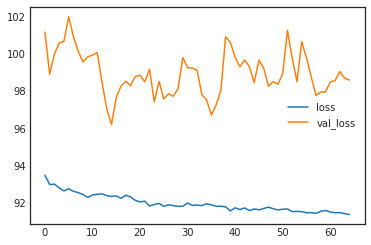

In [621]:
early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
time1 = time.time()
optimizer_adam = tf.keras.optimizers.Adam()
model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_snn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn.predict(X_train)), 
       r2_score(y_val, model_snn.predict(X_val)),
       r2_score(y_test, model_snn.predict(X_test))])
print(time.time()-time1)

In [180]:
X_val

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0
36,-0.612479,0.093461,0.719846,-0.253931,-0.987864,-0.395222,-0.839787,1.311527,-0.698449,-1.107615,-1.085305,-0.948009,-1.107851,-1.061303,-1.091215,-1.263500,0.728270,0.542291,-0.049710,-0.915318,-0.071219,0.559899,-0.568393,-1.113677,-0.409735,0.517731,-0.304907,-0.783420,-0.352128,-1.113677,-0.411241,-0.760507,-0.692327,-0.586912,-0.825575,-1.116346,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,-1.098087,-1.056204,1.111671,-1.729057,-0.621714,-0.126246,0.660355,-0.027070,1.122396,0.783425,0.489108,1.326108,0.371155,0.568497,0.759708,1.631631,-0.854679,0.452220,-0.846728,-0.549495,1.558847,-1.028437,1.177818,-0.535184,1.247437,3.053172,1.301634,0.122334,0.986915,-0.535184,-1.636807,1.061128,0.793389,1.587190,2.139835,1.972031,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,-1.017334,-0.761409,1.163306,-0.309223,-0.278237,-0.481448,-0.022911,0.048652,0.852550,-0.339425,-0.179673,-0.820050,-0.097148,-0.476122,-0.802269,-0.445159,-0.254341,0.442542,0.724077,0.114054,-0.820425,-0.272731,0.854642,0.216873,0.845819,-0.845943,0.993837,1.109063,0.993492,0.216873,-1.113882,-0.611153,-0.402149,-1.157941,-0.417698,-0.258807,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,-1.100278,0.032686,1.092450,-0.504720,-0.889660,-0.659544,-1.199866,1.311926,-0.833087,-0.445394,-0.390569,0.285349,-0.821593,-0.403480,-0.736434,-0.756806,0.622390,1.436114,-0.562715,-0.848914,-0.316655,0.449012,-0.691659,-0.941756,-0.533623,-0.683832,-0.445939,-0.706069,-0.499549,-0.941756,-0.972298,0.549475,0.642682,0.364889,0.145648,-0.157740,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,-0.760740,0.149421,1.087237,-0.416474,-0.963139,-0.602710,-0.484662,1.991333,-1.277050,-0.865144,-0.816650,0.219649,-0.739330,-0.826352,-0.666444,-0.748998,1.354701,0.958646,-0.268558,-0.894380,-0.716941,1.088137,-1.165634,0.158669,-1.071988,-0.215578,-0.998049,-0.794888,-1.066169,0.158669,-1.147174,0.641499,0.811720,0.080118,-0.033113,-0.319384,-0.300695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.